# Анализ спроса на самокаты

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, shapiro, mannwhitneyu, kruskal
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Предобработка данных о погоде

In [311]:
# Чтение данных и удаление первой строки с единицами измерения
df = pd.read_csv('weather.csv', na_values="", parse_dates=['Datetime']).drop(index=0, axis=1)

# Названия колонок к PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()

df.head()

datetime temperature precipitation_total wind_gust wind_speed  \
1 2023-04-01 00:00:00    8.740245                 0.1      48.6  21.638964   
2 2023-04-01 01:00:00    9.040245                 0.2     55.44  22.493519   
3 2023-04-01 02:00:00    8.880245                 0.3      55.8   22.26477   
4 2023-04-01 03:00:00    8.690246                 0.3     55.44   21.94524   
5 2023-04-01 04:00:00    8.630245                 0.3     48.96   22.42427   

  cloud_cover_total sunshine_duration  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0  
5                78                 0

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 1 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   object        
 2   precipitation_total  3642 non-null   object        
 3   wind_gust            3672 non-null   object        
 4   wind_speed           3656 non-null   object        
 5   cloud_cover_total    3652 non-null   object        
 6   sunshine_duration    3660 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 200.9+ KB


У всех столбцов, кроме даты, неверный тип данных

In [313]:
# Приведение колонок к float, кроме колонки с датами
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 1 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   float64       
 2   precipitation_total  3642 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3656 non-null   float64       
 5   cloud_cover_total    3652 non-null   float64       
 6   sunshine_duration    3660 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


### Проверка на дубликаты

In [314]:
# Проверим на дубликаты как полную строку, так и дату отдельно.
# Другие столбцы имеют право повторяться
df.duplicated().sum(), df['datetime'].duplicated().sum()

(np.int64(0), np.int64(0))

Дубликаты отсутствуют

### Работа с пропусками

In [315]:
df.isna().sum() # Проверка наличия пропусков

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

Посмотрим на длины подряд идущих пропусков в столбцах, где они есть

In [316]:
na_lens = {}

for col in df.columns.drop(['datetime', 'wind_gust']):
        # Получаем длины подряд идущих пропусков
        lengths = (
            df[col].isna()
            .groupby(df[col].isna().ne(df[col].isna().shift()).cumsum())
            .sum()
        )

        # Добавляем в словарик сортированные длины
        na_lens[col] = sorted(lengths[lengths > 0].tolist())
    
na_lens

{'temperature': [3, 5, 6, 8, 10, 23],
 'precipitation_total': [3, 4, 9, 14],
 'wind_speed': [3, 4, 4, 5],
 'cloud_cover_total': [3, 3, 6, 8],
 'sunshine_duration': [3, 4, 5]}

Пропуски маленькой длины (<= 5) будем заполнять **интерполяцией**, т.к. за 5 часов погода изменится не сильно.<br>
Пропуски уже большой длины заполним с помощью **регрессии**

In [317]:
# Сортируем данные по дате
df = df.sort_values('datetime')

Найдем начальный и конечный индекс у каждой последовательности пропусков.<br>
Последовательность длиной <= 5 будем использовать для интерполяции, остальные для регрессии

In [302]:
interpolate_ranges = {} # Промежутки для интерполяции
regression_ranges = {} # Промежутки для регрессии

for col in df.columns.drop(['datetime', 'wind_gust']):
    # Получаем индексы пропусков для текущего столбца
    miss_indexes = df[col][df[col].isna()].index

    i_ranges, r_ranges = [], []
    start = None

    for i in range(len(miss_indexes)):
        if start is None:
            start = miss_indexes[i]
        
        # Проверяем, является ли текущий индекс частью подряд идущих пропусков
        if i == len(miss_indexes) - 1 or miss_indexes[i + 1] != miss_indexes[i] + 1:
            # Количество подряд идущих пропусков
            gap_length = miss_indexes[i] - start + 1
            
            if gap_length <= 5: # Интерполяция
                i_ranges.append((int(start), int(miss_indexes[i])))
            else: # Регрессия
                r_ranges.append((int(start), int(miss_indexes[i])))

            start = None

    if i_ranges: interpolate_ranges[col] = i_ranges
    if r_ranges: regression_ranges[col] = r_ranges

interpolate_ranges

{'temperature': [(1116, 1118), (2521, 2525)],
 'precipitation_total': [(1521, 1523), (2686, 2689)],
 'wind_speed': [(935, 938), (1296, 1300), (1921, 1923), (2185, 2188)],
 'cloud_cover_total': [(2573, 2575), (2790, 2792)],
 'sunshine_duration': [(1555, 1559), (1692, 1694), (2841, 2844)]}

In [318]:
regression_ranges

{'temperature': [(363, 372), (1006, 1013), (2506, 2511), (3054, 3076)],
 'precipitation_total': [(2403, 2411), (2716, 2729)],
 'cloud_cover_total': [(1694, 1699), (2053, 2060)]}

#### ДО ИНТЕРПОЛЯЦИИ

In [319]:
df.iloc[2518:2527]

datetime  temperature  precipitation_total  wind_gust  \
2519 2023-07-14 22:00:00    21.290245                  0.0  16.919998   
2520 2023-07-14 23:00:00    20.620245                  0.0  17.640000   
2521 2023-07-15 00:00:00          NaN                  0.0  17.640000   
2522 2023-07-15 01:00:00          NaN                  0.0  17.280000   
2523 2023-07-15 02:00:00          NaN                  0.0  16.919998   
2524 2023-07-15 03:00:00          NaN                  0.0  16.919998   
2525 2023-07-15 04:00:00          NaN                  0.0  16.919998   
2526 2023-07-15 05:00:00    19.320246                  0.0  17.640000   
2527 2023-07-15 06:00:00    22.450245                  0.0  18.359999   

      wind_speed  cloud_cover_total  sunshine_duration  
2519    4.735060                0.0           0.000000  
2520    4.802999                0.0           0.000000  
2521    5.014219               11.0           0.000000  
2522    4.829907               23.0           0.000000  
2523    5.191994               13.0           0.000000  
2524    5.991594               15.0           0.000000  
2525    5.804825                5.0          14.353199  
2526    6.915374                7.0          55.757576  
2527    5.860375               13.0          52.121212

In [320]:
# Используем интерполяцию
for col, ranges in interpolate_ranges.items():
    for r in ranges:
        # Т.к. интерполяция отталкивается от значений соседних точек, нужно сместить начальный и конечный индекс
        s, e = r[0] - 1, r[1] + 1 
        df.loc[s:e, col] = df.loc[s:e, col].interpolate()


#### ПОСЛЕ ИНТЕРПОЛЯЦИИ

In [321]:
df.iloc[2518:2527]

datetime  temperature  precipitation_total  wind_gust  \
2519 2023-07-14 22:00:00    21.290245                  0.0  16.919998   
2520 2023-07-14 23:00:00    20.620245                  0.0  17.640000   
2521 2023-07-15 00:00:00    20.403579                  0.0  17.640000   
2522 2023-07-15 01:00:00    20.186912                  0.0  17.280000   
2523 2023-07-15 02:00:00    19.970246                  0.0  16.919998   
2524 2023-07-15 03:00:00    19.753579                  0.0  16.919998   
2525 2023-07-15 04:00:00    19.536912                  0.0  16.919998   
2526 2023-07-15 05:00:00    19.320246                  0.0  17.640000   
2527 2023-07-15 06:00:00    22.450245                  0.0  18.359999   

      wind_speed  cloud_cover_total  sunshine_duration  
2519    4.735060                0.0           0.000000  
2520    4.802999                0.0           0.000000  
2521    5.014219               11.0           0.000000  
2522    4.829907               23.0           0.000000  
2523    5.191994               13.0           0.000000  
2524    5.991594               15.0           0.000000  
2525    5.804825                5.0          14.353199  
2526    6.915374                7.0          55.757576  
2527    5.860375               13.0          52.121212

#### ДО РЕГРЕССИИ

In [322]:
df.iloc[1004:1014]

datetime  temperature  precipitation_total  wind_gust  \
1005 2023-05-12 20:00:00    13.690246                  0.0  14.400000   
1006 2023-05-12 21:00:00          NaN                  0.0  12.959999   
1007 2023-05-12 22:00:00          NaN                  0.0  14.040000   
1008 2023-05-12 23:00:00          NaN                  0.0  14.040000   
1009 2023-05-13 00:00:00          NaN                  0.0  13.679999   
1010 2023-05-13 01:00:00          NaN                  0.0  12.959999   
1011 2023-05-13 02:00:00          NaN                  0.0  12.599999   
1012 2023-05-13 03:00:00          NaN                  0.0  11.159999   
1013 2023-05-13 04:00:00          NaN                  0.0  10.799999   
1014 2023-05-13 05:00:00    11.870245                  0.0  11.520000   

      wind_speed  cloud_cover_total  sunshine_duration  
1005    5.506941               26.0           0.000000  
1006    6.569383               20.0           0.000000  
1007    7.244860               38.0           0.000000  
1008    6.618519               38.0           0.000000  
1009    7.729527               25.0           0.000000  
1010    7.172949               23.7           0.000000  
1011    8.557102               23.1           0.000000  
1012    6.725354               59.0           0.000000  
1013    6.638072               77.0           1.440741  
1014    6.877790               91.0           4.848486

In [323]:
for col in regression_ranges:
    train_df = df.dropna() # Убираем пропуски для обучения модели
    
    X = train_df.drop(columns=[col, 'datetime']) # Признаки 
    y = train_df[col] # Целевая переменная

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.33, random_state=42)

    # Создаем и обучаем модель линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)

    test_df = df[df[col].isna()]  # Данные с пропусками в целевой переменной
    X_test = test_df.drop(columns=[col, 'datetime'])  # Признаки для предсказания
    predictions = model.predict(X_test)

    # Заполняем пропуски в целевой переменной
    df.loc[df[col].isna(), col] = predictions

#### ПОСЛЕ РЕГРЕССИИ

In [324]:
df.iloc[1004:1014]

datetime  temperature  precipitation_total  wind_gust  \
1005 2023-05-12 20:00:00    13.690246                  0.0  14.400000   
1006 2023-05-12 21:00:00    14.396316                  0.0  12.959999   
1007 2023-05-12 22:00:00    13.863751                  0.0  14.040000   
1008 2023-05-12 23:00:00    14.159264                  0.0  14.040000   
1009 2023-05-13 00:00:00    13.898614                  0.0  13.679999   
1010 2023-05-13 01:00:00    14.009935                  0.0  12.959999   
1011 2023-05-13 02:00:00    13.279870                  0.0  12.599999   
1012 2023-05-13 03:00:00    12.784216                  0.0  11.159999   
1013 2023-05-13 04:00:00    12.413884                  0.0  10.799999   
1014 2023-05-13 05:00:00    11.870245                  0.0  11.520000   

      wind_speed  cloud_cover_total  sunshine_duration  
1005    5.506941               26.0           0.000000  
1006    6.569383               20.0           0.000000  
1007    7.244860               38.0           0.000000  
1008    6.618519               38.0           0.000000  
1009    7.729527               25.0           0.000000  
1010    7.172949               23.7           0.000000  
1011    8.557102               23.1           0.000000  
1012    6.725354               59.0           0.000000  
1013    6.638072               77.0           1.440741  
1014    6.877790               91.0           4.848486

Проверим работу

In [325]:
df.isna().sum()

datetime               0
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64

### Проверка на выбросы

In [623]:
df.describe().round(2)

datetime  temperature  precipitation_total  \
count                           3672      3672.00              3672.00   
mean   2023-06-16 11:30:00.000000256        18.12                 0.10   
min              2023-04-01 00:00:00        -2.08                -0.02   
25%              2023-05-09 05:45:00        13.30                 0.00   
50%              2023-06-16 11:30:00        18.04                 0.00   
75%              2023-07-24 17:15:00        22.95                 0.00   
max              2023-08-31 23:00:00        36.15                 5.80   
std                              NaN         6.81                 0.34   

       wind_gust  wind_speed  cloud_cover_total  sunshine_duration  
count    3672.00     3672.00            3672.00            3672.00  
mean       20.89        7.35              40.97              21.54  
min         2.88        0.00              -2.85               0.00  
25%        13.32        4.33              15.00               0.00  
50%        18.36        6.29              32.00              15.15  
75%        26.28        9.47              67.00              42.55  
max        71.28       29.97             100.00              60.00  
std        10.44        4.26              31.32              21.88

Все значения находятся в норме, выбросов не наблюдается

### Выгрузка новой таблицы

In [624]:
# Добавляем единицы измерения в начало таблицы
units_of_measure = ["", "°C", "mm", "km/h", "km/h", "%", "min"]
first_row = pd.DataFrame([units_of_measure], columns=df.columns, index=[0]) 
df = pd.concat([first_row, df], ignore_index=True)

df.to_csv('processed_weather.csv', index=False)

## Предобработка данных о поездках

In [626]:
# Чтение данных
df = pd.read_csv('rides.csv', na_values="", parse_dates=['Start Date', 'End Date'])

# Названия колонок к PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()

### Проверка на единый формат данных

Проверим, записаны ли данные про район и улицу в едином формате

In [546]:
print(df['end_district'].unique())
print(df['start_district'].unique())

['Октябрьский' 'октябрьский' 'ленинский' 'Северо-Западный' 'Юго-Восточный'
 'Ленинский' 'юго-восточный' 'Центральный' 'центральный' 'Заречный'
 'северо-западный' 'заречный' 'Северо Западный' 'северо западный']
['Юго-Восточный' 'заречный' 'Октябрьский' 'Центральный' 'Северо-Западный'
 'Ленинский' 'ленинский' 'центральный' 'Заречный' 'юго-восточный'
 'северо-западный' 'октябрьский' 'северо западный']


Районы записаны не в едином формате, нужно будет привести их к единому формату. Теперь проверим точки начала и конца

In [547]:
df['end_location'].unique()

array(['Майская', 'Спортивная', 'Суворова', 'Рабочая', 'Юбилейная',
       'Западная', 'Свободы', 'ул. западная', 'Озерная', 'ул. чкалова',
       'Строителей', 'ул. спортивная', 'Красная', 'Ул. Крупской',
       'ул.почтовая', 'гоголя', 'Сиреневая', 'ул.южная', 'Шоссейная',
       'Трудовая', 'Дружбы', 'Почтовая', 'Южная', 'космонавтов',
       'шевченко', 'ул. набережная', 'вишневая', 'Совхозная',
       'ул сосновая', 'ул. вишневая', 'Куйбышева', 'Степная', 'береговая',
       'Луговая', 'Чкалова', 'Свердлова', 'Матросова', 'березовая',
       'ломоносова', 'Первомайская', 'Космонавтов', 'ул. матросова',
       'вокзальная', 'Зеленая', 'ул. березовая', 'ул.ленина', 'ул.дружбы',
       'Солнечная', 'ленина', 'ул.красноармейская', 'Железнодорожная',
       'красноармейская', 'степная', 'ул. лермонтова', 'ул.матросова',
       'Карла Маркса', 'Березовая', 'Овражная', 'Ленина',
       'ул.строительная', 'Речная', 'Заводская', 'Школьная',
       'ул. трудовая', 'майская', 'Чапаева', 'ул.

In [548]:
df['start_location'].unique()

array(['Шевченко', 'Чехова', 'Буденного', 'Труда', 'Первомайская',
       'Лесная', 'Пролетарская', 'Комарова', 'Западная', 'Свободы',
       'Коммунальная', 'Зеленая', 'Шоссейная', 'Центральная', 'буденного',
       'новая', 'Энтузиастов', 'ул.подгорная', 'Восточная', 'Лермонтова',
       'Школьная', 'Пушкина', 'подгорная', 'рябиновая', 'Солнечная',
       'Мичурина', 'ул труда', 'Партизанская', 'Вокзальная',
       'Комсомольская', 'майская', 'Красноармейская', 'Рабочая',
       'Почтовая', 'дачная', 'Заводская', 'Ломоносова', 'карла маркса',
       'Советская', 'Красная', 'Дзержинского', 'Рябиновая',
       'ул.советская', 'ул.энергетиков', 'Пионерская', 'ленина',
       'ул. сиреневая', 'гагарина', 'юбилейная', 'Цветочная',
       'ул. набережная', 'Сосновая', 'Спортивная', 'Новая', 'Ленина',
       'Полевая', 'ул. строительная', 'Майская', 'Озерная', 'ул.горького',
       'ул. восточная', 'пионерская', 'Энергетиков', 'ул.озерная',
       'южная', 'Некрасова', 'ул.молодежная', 'ул.

Точки начала и конца поездки тоже нужно приводить к единому формату. Сделаем это.

In [549]:
# Приводим значения направлений движения к единому формату
df['end_district'] = df['end_district'].str.lower().str.strip().str.replace(" ", '-')
df['start_district'] = df['start_district'].str.lower().str.strip().str.replace(" ", '-')

# Приводим значения начальных и конечных точек к единому формату
df['start_location'] = df['start_location'].str.lower().str.strip().str.replace(".", ' ').str.replace("  ", ' ')
df['start_location'] = df['start_location'].str.replace('ул ', '')

df['end_location'] = df['end_location'].str.lower().str.strip().str.replace(".", ' ').str.replace("  ", ' ')
df['end_location'] = df['end_location'].str.replace('ул ', '')

Проверим результат

In [550]:
print(df['end_district'].unique())
print(df['start_district'].unique())
print(df['end_location'].unique())
print(df['start_location'].unique())

['октябрьский' 'ленинский' 'северо-западный' 'юго-восточный' 'центральный'
 'заречный']
['юго-восточный' 'заречный' 'октябрьский' 'центральный' 'северо-западный'
 'ленинский']
['майская' 'спортивная' 'суворова' 'рабочая' 'юбилейная' 'западная'
 'свободы' 'озерная' 'чкалова' 'строителей' 'красная' 'крупской'
 'почтовая' 'гоголя' 'сиреневая' 'южная' 'шоссейная' 'трудовая' 'дружбы'
 'космонавтов' 'шевченко' 'набережная' 'вишневая' 'совхозная' 'сосновая'
 'куйбышева' 'степная' 'береговая' 'луговая' 'свердлова' 'матросова'
 'березовая' 'ломоносова' 'первомайская' 'вокзальная' 'зеленая' 'ленина'
 'солнечная' 'красноармейская' 'железнодорожная' 'лермонтова'
 'карла маркса' 'овражная' 'строительная' 'речная' 'заводская' 'школьная'
 'чапаева' 'коммунальная' 'буденного' 'северная' 'мира' 'полевая'
 'садовая' 'партизанская' 'заречная' 'новая' 'пионерская' 'советская'
 'нагорная' 'энтузиастов' 'дорожная' 'колхозная' 'рябиновая' 'московская'
 'гагарина' 'подгорная' 'энергетиков' 'горького' 'дзержин

Отлично, теперь все данные представленны в едином формате

### Проверка на дубликаты

Повторяться могут все данные, кроме id, так как id является <u>уникальным</u> идектификатором.

In [551]:
print(df.duplicated().sum(), df.duplicated('id').sum())

4883 4883


Повторяются только строки с одинаковыми id. Рассмотрим такие строки

In [552]:
df[df['id'] == 197640]

id          start_date            end_date start_location  \
102180  197640 2023-07-31 21:43:19 2023-07-31 21:58:08         кирова   
102181  197640 2023-07-31 21:43:19 2023-07-31 21:58:08         кирова   

       start_district  end_location   end_district  distance  promo  
102180      ленинский  коммунальная  юго-восточный   2809.00      0  
102181      ленинский  коммунальная  юго-восточный   2809.00      0

Не может быть, чтобы дублировались id. Так как все остальные данные тоже равны, то можно сделать вывод, что имела место ошибка в системе сохранения данных о поездках. Вероятно, из-за какой-то ошибки информация о поездки сохранилась в rides.csv дважды. Поэтому удаляем дубликаты и проверяем результат

In [553]:
# Удаляем дубликаты и обновляем индексацию
df = df.drop_duplicates()
df = df.reset_index(drop=True)

# Проверка
print(df.duplicated().sum(), df.duplicated('id').sum())

0 0


Отлично, больше дубликатов нет

### Работа с пропусками

In [554]:
df.isna().sum() # Проверка наличия пропусков

id                   0
start_date           0
end_date           555
start_location       0
start_district       0
end_location         0
end_district         0
distance          1181
promo                0
dtype: int64

Наблюдаются пропуски в дате окончания поездки и дистанции поездки.

* Пропуски в end_date будем заполнять на основании пройденной дистанции

* Пропуски в distance будем заполнять на основании времени поездки

#### Работа с пропусками в end_date

Рассчитывать время конца поездки будем на основании медианы средней скорости во время пути и дистанции поездки.

Формула: Конец_поездки = начало_поездки + (дистанция / медиана_средней_скорости)

##### ДО

In [555]:
df.iloc[946:949]

id          start_date            end_date start_location  \
946  101286 2023-04-22 23:33:50                 NaT         чехова   
947  101287 2023-04-22 23:35:04 2023-04-22 23:54:26      советская   
948  101288 2023-04-22 23:36:43 2023-04-23 00:14:03         кирова   

    start_district end_location end_district  distance  promo  
946       заречный  октябрьская     заречный   2521.00      0  
947    центральный     суворова    ленинский   3204.00      0  
948      ленинский    буденного  октябрьский   3755.00      0

##### ПОСЛЕ

In [556]:
# Создаем колонну ride_duration, которая содержит длительность поездки в минутах
df['ride_duration'] = (df.end_date - df.start_date).dt.seconds / 60 

# Создаем колонку average_speed, которая хранит среднюю скорость на протяжении всего пути в км/ч
df['average_speed'] = (df.distance / 1000) / (df.ride_duration / 60)

median_average_speed = df['average_speed'].median()

# Заполнение пустых значений в столбце 'end_date'
df['end_date'] = df['end_date'].fillna(
    df['start_date'] + pd.to_timedelta((df['distance'] / 1000) / median_average_speed, unit='h')
)

df.iloc[946:949]

id          start_date                      end_date start_location  \
946  101286 2023-04-22 23:33:50 2023-04-22 23:50:25.672184098         чехова   
947  101287 2023-04-22 23:35:04 2023-04-22 23:54:26.000000000      советская   
948  101288 2023-04-22 23:36:43 2023-04-23 00:14:03.000000000         кирова   

    start_district end_location end_district  distance  promo  ride_duration  \
946       заречный  октябрьская     заречный   2521.00      0            NaN   
947    центральный     суворова    ленинский   3204.00      0          19.37   
948      ленинский    буденного  октябрьский   3755.00      0          37.33   

     average_speed  
946            NaN  
947           9.93  
948           6.03

#### Работа с пропусками в distance

Рассчитывать дистанцию поездки будем на основании медианы средней скорости во время пути и длительности поездки.

Формула: Дистанция = медиана_средней_скорости * время_поездки

##### ДО

In [557]:
df.iloc[1130:1133]

id          start_date            end_date start_location  \
1130  101470 2023-04-23 11:26:28 2023-04-23 12:10:50         речная   
1131  101471 2023-04-23 11:27:21 2023-04-23 11:47:01       комарова   
1132  101472 2023-04-23 11:28:32 2023-04-23 11:50:19        майская   

     start_district end_location   end_district  distance  promo  \
1130  юго-восточный   пионерская       заречный       NaN      0   
1131      ленинский       дружбы    центральный   3581.00      0   
1132    октябрьский   молодежная  юго-восточный   3082.00      0   

      ride_duration  average_speed  
1130          44.37            NaN  
1131          19.67          10.93  
1132          21.78           8.49

##### ПОСЛЕ

In [558]:
# Заполнение пустых значений в столбце 'distance'
df['distance'] = df['distance'].fillna(median_average_speed * (df['ride_duration'] / 60) * 1000)

df.iloc[1130:1133]

id          start_date            end_date start_location  \
1130  101470 2023-04-23 11:26:28 2023-04-23 12:10:50         речная   
1131  101471 2023-04-23 11:27:21 2023-04-23 11:47:01       комарова   
1132  101472 2023-04-23 11:28:32 2023-04-23 11:50:19        майская   

     start_district end_location   end_district  distance  promo  \
1130  юго-восточный   пионерская       заречный   6740.07      0   
1131      ленинский       дружбы    центральный   3581.00      0   
1132    октябрьский   молодежная  юго-восточный   3082.00      0   

      ride_duration  average_speed  
1130          44.37            NaN  
1131          19.67          10.93  
1132          21.78           8.49

#### Проверка работы

In [559]:
df = df.drop(['ride_duration', 'average_speed'], axis=1) # Удаляем уже ненужные стоблцы

df.isna().sum() # Проверка наличия пропусков

id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64

### Проверка на выбросы

In [560]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

id                     start_date                       end_date  \
count  97372.00                          97372                          97372   
mean  149025.50  2023-06-13 21:06:08.931407360  2023-06-13 21:33:03.576468480   
min   100340.00            2023-04-22 09:01:03            2023-04-22 09:24:45   
25%   124682.75     2023-05-20 21:41:39.500000            2023-05-20 22:07:59   
50%   149025.50            2023-06-14 15:15:46            2023-06-14 15:44:53   
75%   173368.25  2023-07-08 19:50:22.249999872            2023-07-08 20:18:30   
max   197711.00            2023-07-31 23:57:01  2023-08-14 07:25:37.719536260   
std    28109.02                            NaN                            NaN   

        distance    promo  
count   97372.00 97372.00  
mean    26998.68     0.02  
min         1.00     0.00  
25%      3044.00     0.00  
50%      3703.00     0.00  
75%      4433.00     0.00  
max   7569789.00     1.00  
std    307435.12     0.14

В distance присутствуют очень сильные выбросы, вероятно, они вызваны либо ошибками в системе сохранения данных о поездках, либо ошибками в датчиках на стороне пользователя или самоката.

Так как выбросы в distance аномально большие или маленькие, то самым простым способом будет вручную отфильтровать выбросы и исправить ошибочные значения, не прибегая к интерквартильному размаху или стандартным отклонениям

Выбросы будем исправлять по аналогии с пропусками, то есть через формулу:
 Дистанция = медиана_средней_скорости * время_поездки

##### Удаление данных, которые невозможно восстановить

Некоторые строки с выбросами также содержали пустые данные и на этапе заполнения пустых данных, заполненные пропуски тоже получили некорректные значения. При условии, что один из параметров выброс, а другой был пропущен - мы не можем восстановить данные, следовательно придется их удалить.

Так как при заполнении пропусков в end_date мы использовали distance, а выбросы наблюдаются только в distance, то легче всего будет найти данные, которые нельзя восстановить через end_date, а точнее через время поездки. Так как выбросы в distance либо аномально большие, либо аномально маленькие, то и значения, которые нельзя восстановить будут иметь либо аномально большую, либо аномально маленькую длительность поездки.

In [561]:
# Обновляем значения в колонке ride_duration
df['ride_duration'] = (df.end_date - df.start_date).dt.seconds / 60

df['ride_duration'].describe()

count   97372.00
mean       26.38
std        10.42
min         0.00
25%        19.48
50%        24.62
75%        31.22
max       774.90
Name: ride_duration, dtype: float64

Так как max больше на 2500%, чем 75 квартиль, а min вообще равен 0, то будет легче всего вручную удалить данные, которые невозможно восстановить

Возьмем примерные значения, в которых должны лежать выбросы. Пусть верхнее значение будет > 100 минут, а нижнее < 2 минут

Проверим верхнее значение

In [562]:
df[(df['ride_duration'] > 100)]

id          start_date                      end_date  \
9664   110004 2023-05-03 18:18:24 2023-05-27 07:13:18.599306918   
97232  197572 2023-07-31 20:51:23 2023-08-14 07:25:37.719536260   

      start_location start_district end_location     end_district   distance  \
9664   комсомольская       заречный    заводская  северо-западный 5149229.00   
97232      юбилейная  юго-восточный     дорожная    юго-восточный 2940248.00   

       promo  ride_duration  
9664       0         774.90  
97232      0         634.23

Действительно, выбросы попадают в его пределы, но стоит проверить нет ли выбросов в большую сторону при ride_duration <= 100

In [563]:
df[(df['ride_duration'] >= 84) & (df['ride_duration'] <= 100)]

id          start_date            end_date start_location  \
10279  110619 2023-05-04 13:34:03 2023-05-04 14:58:46       почтовая   
14594  114934 2023-05-09 00:42:32 2023-05-09 02:06:51       почтовая   
39253  139593 2023-06-04 22:22:35 2023-06-04 23:47:25       крупской   
40710  141050 2023-06-06 16:37:02 2023-06-06 18:01:06      береговая   
52965  153305 2023-06-18 16:11:20 2023-06-18 17:35:42          новая   
53174  153514 2023-06-18 18:13:45 2023-06-18 19:38:31       дорожная   
63823  164163 2023-06-29 19:58:45 2023-06-29 21:22:48        красная   
72541  172881 2023-07-08 16:04:24 2023-07-08 17:28:45      шоссейная   
78706  179046 2023-07-14 13:30:58 2023-07-14 14:55:13        майская   
80740  181080 2023-07-16 08:14:54 2023-07-16 09:39:32         победы   
94049  194389 2023-07-29 08:20:10 2023-07-29 09:44:41     вокзальная   

        start_district   end_location     end_district  distance  promo  \
10279    юго-восточный     строителей      центральный   5404.00      0   
14594    юго-восточный      некрасова  северо-западный   5233.00      0   
39253      центральный      цветочная  северо-западный   6188.00      0   
40710      центральный   строительная  северо-западный   5064.00      0   
52965  северо-западный        чкалова    юго-восточный   6326.00      0   
53174    юго-восточный  комсомольская         заречный   5188.00      0   
63823  северо-западный     молодежная    юго-восточный   5589.00      0   
72541         заречный     лермонтова        ленинский   6681.00      0   
78706      октябрьский        свободы        ленинский   3240.00      0   
80740    юго-восточный          новая  северо-западный   6804.00      0   
94049    юго-восточный         чехова         заречный   5380.00      0   

       ride_duration  
10279          84.72  
14594          84.32  
39253          84.83  
40710          84.07  
52965          84.37  
53174          84.77  
63823          84.05  
72541          84.35  
78706          84.25  
80740          84.63  
94049          84.52

Выбросов нет, данные не содержат каких-то ошибок. Следовательно можно удалять значение больше 100.

Проверим нижнее значение

In [564]:
df[(df['ride_duration'] < 2)]

id          start_date                      end_date  \
467    100807 2023-04-22 17:58:05 2023-04-22 17:58:06.579805132   
2412   102752 2023-04-24 19:41:16 2023-04-24 19:41:17.974756412   
2666   103006 2023-04-25 08:47:46 2023-04-25 08:47:47.184853848   
14842  115182 2023-05-09 13:11:54 2023-05-09 13:11:55.184853848   
15738  116078 2023-05-10 18:54:16 2023-05-10 18:54:17.974756412   
20838  121178 2023-05-16 18:30:32 2023-05-16 18:30:33.579805132   
26609  126949 2023-05-23 06:44:52 2023-05-23 06:44:53.579805132   
43910  144250 2023-06-09 21:59:33 2023-06-09 21:59:34.579805132   
44262  144602 2023-06-10 11:46:28 2023-06-10 11:46:29.579805132   
53406  153746 2023-06-18 20:30:51 2023-06-18 20:30:52.579805132   
53580  153920 2023-06-18 22:29:02 2023-06-18 22:29:02.789902564   
60030  160370 2023-06-25 18:50:41 2023-06-25 18:50:42.974756412   
64176  164516 2023-06-30 12:34:19 2023-06-30 12:34:20.184853848   
70043  170383 2023-07-06 07:40:33 2023-07-06 07:40:34.184853848   
91505  191845 2023-07-26 17:29:08 2023-07-26 17:29:09.184853848   
97088  197428 2023-07-31 19:16:20 2023-07-31 19:16:21.579805132   

      start_location   start_district  end_location     end_district  \
467       ломоносова      октябрьский     цветочная  северо-западный   
2412     октябрьская         заречный      комарова        ленинский   
2666       восточная      октябрьский  строительная  северо-западный   
14842         гоголя      центральный      дорожная    юго-восточный   
15738       мичурина        ленинский     восточная      октябрьский   
20838        майская      октябрьский      гагарина      центральный   
26609       крупской      центральный     буденного      октябрьский   
43910    энтузиастов      центральный    спортивная      октябрьский   
44262     спортивная      октябрьский         труда      центральный   
53406        красная  северо-западный   центральная    юго-восточный   
53580        майская      октябрьский     восточная      октябрьский   
60030        майская      октябрьский      вишневая    юго-восточный   
64176     пионерская         заречный        чехова         заречный   
70043   пролетарская      центральный     береговая      центральный   
91505      березовая  северо-западный     береговая      центральный   
97088          южная      центральный       чапаева  северо-западный   

       distance  promo  ride_duration  
467        4.00      0           0.02  
2412       5.00      0           0.02  
2666       3.00      0           0.02  
14842      3.00      0           0.02  
15738      5.00      0           0.02  
20838      4.00      0           0.02  
26609      4.00      0           0.02  
43910      4.00      0           0.02  
44262      4.00      0           0.02  
53406      4.00      0           0.02  
53580      2.00      0           0.00  
60030      5.00      0           0.02  
64176      3.00      0           0.02  
70043      3.00      0           0.02  
91505      3.00      0           0.02  
97088      4.00      0           0.02

Действительно, выбросы попадают в его пределы, но стоит проверить нет ли ещё выбросов в меньшую сторону при ride_duration >= 2

In [565]:
df[(df['ride_duration'] >= 2) & (df['ride_duration'] < 4)]

id          start_date            end_date start_location  \
14291  114631 2023-05-08 17:31:09 2023-05-08 17:34:57       суворова   
63130  163470 2023-06-29 00:59:36 2023-06-29 01:03:11   коммунальная   
86714  187054 2023-07-22 00:26:46 2023-07-22 00:29:20       овражная   

      start_district  end_location   end_district  distance  promo  \
14291      ленинский   энергетиков  юго-восточный    757.00      0   
63130  юго-восточный  карла маркса      ленинский    579.00      0   
86714    центральный      вишневая  юго-восточный    519.00      0   

       ride_duration  
14291           3.80  
63130           3.58  
86714           2.57

Все значения выглядят корректно, выбросов нет. Следователь, можно удалять значения < 2.

Теперь можно удалять все значения, которые нельзя восстановить

In [566]:
# Удаляем значения, которые невозможно восстановить и обновляем индексацию
df = df[(df['ride_duration'] < 100) & (df['ride_duration'] > 2)]
df = df.reset_index(drop=True)

##### Работа с выбросами

Определим верхнюю и нижнюю границу для выбросов в distance. Использовать интерквартильный размах бесполезно из-за слишком больших выбросов.

Пусть верхнейй границей будет дистанция > 50000 метров, а нижнее < 100 метров

Проверим верхнюю границу

In [567]:
df[(df['distance'] > 50000)]['distance'].min()

np.float64(1019979.0)

Действительно, только выбросы попадают в его пределы, но стоит проверить нет ли ещё выбросов в большую сторону при distance <= 50000

In [568]:
df[df['distance'] <= 50000]['distance'].max()

np.float64(12393.933663191114)

Выбросов нет, данные не содержат каких-то ошибок. Следовательно можно исправлять значение больше 50000.

Проверим нижнюю границу

In [569]:
df[(df['distance'] < 100)]['distance'].max()

np.float64(8.0)

Действительно, только выбросы попадают в его пределы, но стоит проверить нет ли ещё выбросов в меньшую сторону при distance >= 100

In [570]:
df[df['distance'] >= 100]['distance'].min()

np.float64(519.0)

Выбросов нет, данные выглядят корректно. Следовательно можно исправлять значения меньше 100.

Таким образом мы определили границы в которых лежат выбросы. Или выбросы > 50000 или выбросы < 100

ДО

In [571]:
df.iloc[956:959]

id          start_date            end_date start_location  \
956  101297 2023-04-22 23:49:17 2023-04-23 00:21:38     молодежная   
957  101298 2023-04-22 23:52:20 2023-04-23 00:36:54   строительная   
958  101299 2023-04-22 23:54:39 2023-04-23 00:23:58         дачная   

      start_district end_location   end_district   distance  promo  \
956    юго-восточный       победы  юго-восточный    4444.00      0   
957  северо-западный      майская    октябрьский    4659.00      0   
958      центральный      свободы      ленинский 4273850.00      0   

     ride_duration  
956          32.35  
957          44.57  
958          29.32

ПОСЛЕ

In [572]:
# Заменяем выбросы в соответствии с формулой
df['distance'] = df['distance'].where(
    (df['distance'] >= 10) & (df['distance'] <= 50000), 
    median_average_speed * (df['ride_duration'] / 60) * 1000
).round().astype(int)

df.iloc[956:959]

id          start_date            end_date start_location  \
956  101297 2023-04-22 23:49:17 2023-04-23 00:21:38     молодежная   
957  101298 2023-04-22 23:52:20 2023-04-23 00:36:54   строительная   
958  101299 2023-04-22 23:54:39 2023-04-23 00:23:58         дачная   

      start_district end_location   end_district  distance  promo  \
956    юго-восточный       победы  юго-восточный      4444      0   
957  северо-западный      майская    октябрьский      4659      0   
958      центральный      свободы      ленинский      4454      0   

     ride_duration  
956          32.35  
957          44.57  
958          29.32

#### Проверка работы

In [573]:
# Удаляем теперь ненужные колонны таблицы
df = df.drop(['ride_duration'], axis=1) 

df.describe()

id                     start_date                       end_date  \
count  97354.00                          97354                          97354   
mean  149026.61  2023-06-13 21:07:54.995028736  2023-06-13 21:34:17.120527616   
min   100340.00            2023-04-22 09:01:03            2023-04-22 09:24:45   
25%   124685.25            2023-05-20 21:43:06  2023-05-20 22:09:47.249999872   
50%   149026.50     2023-06-14 15:16:29.500000            2023-06-14 15:46:14   
75%   173369.75            2023-07-08 19:50:35  2023-07-08 20:19:23.249999872   
max   197711.00            2023-07-31 23:57:01            2023-08-01 00:42:12   
std    28108.14                            NaN                            NaN   

       distance    promo  
count  97354.00 97354.00  
mean    3829.49     0.02  
min      519.00     0.00  
25%     3102.25     0.00  
50%     3734.00     0.00  
75%     4449.00     0.00  
max    12675.00     1.00  
std     1050.35     0.14

### Проверка на проведение акции 

Стоит проверить использовали ли акцию "Быстрый старт" только указанны срок, то есть с 6 до 10 в понедельник

Сначала проверим, что акцией пользовались только в понедельник

In [594]:
df['start_date'] = pd.to_datetime(df['start_date'])

# Берём только не понедельники
no_monday_df = df[df['start_date'].dt.day_name() != 'Monday']  
no_monday_df['promo'].sum()

np.int64(0)

Отлично, акцией пользовались только по понедельникам

Теперь проверим, что акцию использовали только по понедельникам с 6 до 10

In [595]:
# Берём только понедельники
monday_df = df[df['start_date'].dt.day_name() == 'Monday']  

# Берём только время с 6 до 10 в понедельник
promo_df = monday_df[(monday_df['start_date'].dt.hour >= 6) & (monday_df['start_date'].dt.hour < 10)]

print(f"Всего {monday_df['promo'].sum()} раз воспользовались акцией в понедельник")
print(f"Всего {promo_df['promo'].sum()} раз воспользовались акцией в понедельник c 6:00 до 10:00")

Всего 1911 раз воспользовались акцией в понедельник
Всего 1911 раз воспользовались акцией в понедельник c 6:00 до 10:00


Отлично! Акцией всегда пользовались в срок

### Выгрузка новой таблицы

In [575]:
# Приводим дистанцию к целочисленному типу
df['distance'] = df['distance'].astype(int)

df.to_csv('processed_rides.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

## Объединение таблиц

Для более удобного анализа данных стоит объединить имеющиеся таблицы

In [628]:
rides_df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

rides_df['rounded_start_time'] = rides_df['start_date'].dt.round('h')


merge_df = pd.merge_asof(
    rides_df.sort_values('rounded_start_time'), 
    weather_df.sort_values('datetime'), 
    left_on='rounded_start_time', 
    right_on='datetime', 
    direction='backward'
)

merge_df = merge_df.drop('rounded_start_time', axis=1)

merge_df.to_csv('rides_&_weather.csv', index=False)

## Проведение расчетов и исследований

### 1. Расчет итоговой стоимости

Формула итоговой стоимость:

![alt text](image.png)

Тарифный план:

![alt text](img.png)


Рассчитаем итоговую стоимость и проверим как доход распределены по часам

#### Расчёты

Сначала создадим универсальную функцию, в которую мы передаём датафрейм, а она возвращает новый датафрейм с рассчитанным доходом(новая колонка price)

In [462]:
def calculate_income(df: pd.DataFrame) -> pd.DataFrame:
    # Функция для определения стоимости за минуту
    def calculate_price(row):
        day_of_week = row['start_date'].day_name()
        start_hour = row['start_date'].hour
        
        if 1 <= start_hour < 6:
            return 3
        if 6 <= start_hour < 10:
                return 4

        if day_of_week in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
            if 10 <= start_hour < 16:
                return 5
            elif 16 <= start_hour < 22:
                return 6
            else:
                return 5
        if day_of_week in ['Sunday', 'Saturday']:
            if 10 <= start_hour < 16:
                return 6
            elif 16 <= start_hour < 22:
                return 7
            else:
                return 6


    df = df.copy()
    
    # Рассчитываем стоимость за минуту для каждой строки
    df['price_per_minute'] = df.apply(calculate_price, axis=1)

    # Рассчитываем доход
    df['duration_minutes'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 60
    df['price'] = df['price_per_minute'] * df['duration_minutes']
    
    # Удаяем теперь ненужные колонки
    df = df.drop(['price_per_minute', 'duration_minutes'], axis=1)

    return df

Теперь проведём основные расчёты

In [463]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Рассчитываем доход за каждую поездку
df = calculate_income(df)

# Оставляем только временной промежуток, к которому принадлежит стоимость и стоимость
hour_df = df[['price', 'datetime']]
hour_df['datetime'] = hour_df['datetime'].dt.hour

# Группируем по часам и считаем общий и средний доход
sum_price_df = hour_df.groupby(by=['datetime']).sum()
mean_price_df = hour_df.groupby(by=['datetime'])['price'].mean()

# Группируем по дням недели
day_df = df
day_df['datetime'] = pd.to_datetime(day_df['datetime'])
day_df['day'] = day_df['datetime'].dt.day_name()

#### Визуализация

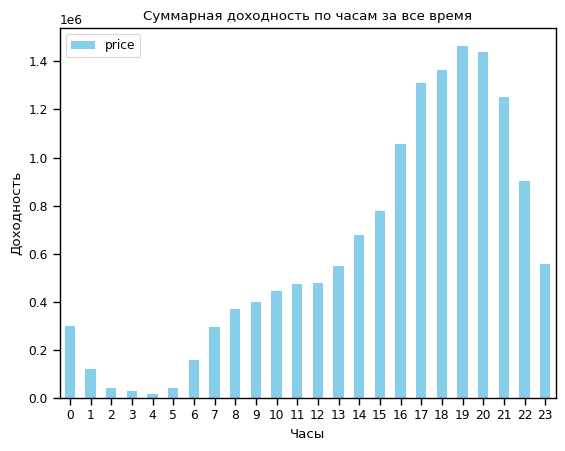

In [464]:
sum_price_df.plot(kind='bar', color='skyblue')
plt.title('Суммарная доходность по часам за все время')
plt.xlabel('Часы')
plt.ylabel('Доходность')
plt.xticks(rotation=0)
plt.show()

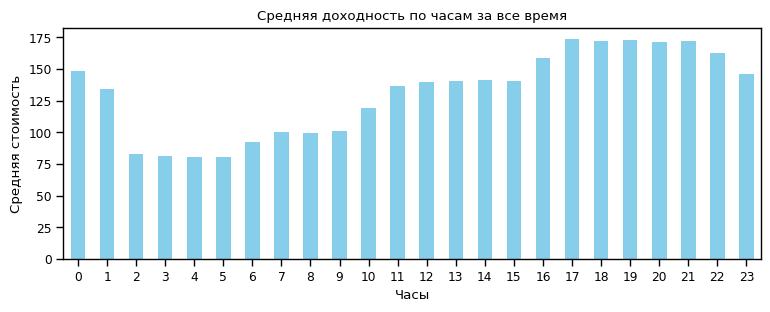

In [465]:
plt.figure(figsize=(9, 3))
mean_price_df.plot(kind='bar', color='skyblue')
plt.title('Средняя доходность по часам за все время')
plt.xlabel('Часы')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=0)
plt.show()


#### Вывод

На основе графического анализа можно сделать следующие выводы:
* Самый большие доходы компания получает с 17:00 и до 21:00. Это логично, тогда самый высокий тариф.
* Самые маленькие доходы компания получает с 2:00 до 5:00. Это логично, так как в это время все спят и в это время самый низкий спрос.
* Доходы с самокатов утром меньше, чем вечером. Это логично, так как тариф в это время в 2 раза меньше.
* Средняя стоимость поездки выше всего после конца рабочего дня. Это логично, тогда самый высокий тариф.
* Средняя стоимость поездки ниже всего ночью. Это логично, так как в это время все спят и в это время самый низкий спрос.

### 2. Стимулирует ли акция спрос на самокаты?

#### Подготовка данных

Так как акция проводится только по понедельникам с 6 до 10. То для анализа стоит брать дни недели, который будут статистически похожи на понедельник. Ближе всего к понедельнику оказалась пятница, но для анализа мы так же дополнительно возьмем вторник, среду и четверг.

In [122]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Берём только поездки с 6 до 10
df = df[(df['start_date'].dt.hour >= 6) & (df['start_date'].dt.hour <= 9)]

# Добавление столбца с днем недели
df['day'] = df['start_date'].dt.day_name()

#### Корреляционный анализ

Мы проверим 2 корреляции: 

1. Зависит ли спрос по утрам от дня недели.
2. Зависит ли спрос по утрам(будем брать данные с пятницы и понедельника) от проведения акции.

Так как в исследованиях, которые проводились до этого, выяснилось, что данные по спросу(поездкам) распределены ненормально, то при расчёте корреляции мы будет использовать критерии Манна-Уитни и Краскела-Уоллеса

##### Зависит ли спрос по утрам по дня недели.

In [123]:
# Подсчет количества поездок по дням недели
rides_per_day = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
grouped_data = [df[df['day'] == day]['id'].values for day in rides_per_day.index]

# Тест Манна-Уитни
stat, p_value = kruskal(*grouped_data)

print(p_value < 0.05)


True


Так как p_value < 0.05, то спрос по утрам действительно зависит от дня недели

##### Зависит ли спрос по утрам от проведения акции.

In [180]:
# Группировка данных по наличию акции
monday_friday_df = df[(df['day'] == 'Monday') | (df['day'] == 'Friday')]

promo_group = monday_friday_df[monday_friday_df['promo'] == 1]  
no_promo_group = monday_friday_df[monday_friday_df['promo'] == 0]

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(promo_group['id'], no_promo_group['id'])

print(p_value < 0.05)

True


Так как p_value < 0.05, то спрос по утрам действительно зависит от проведения акции

#### Графический анализ

Сначала сравним понедельник с другими днями

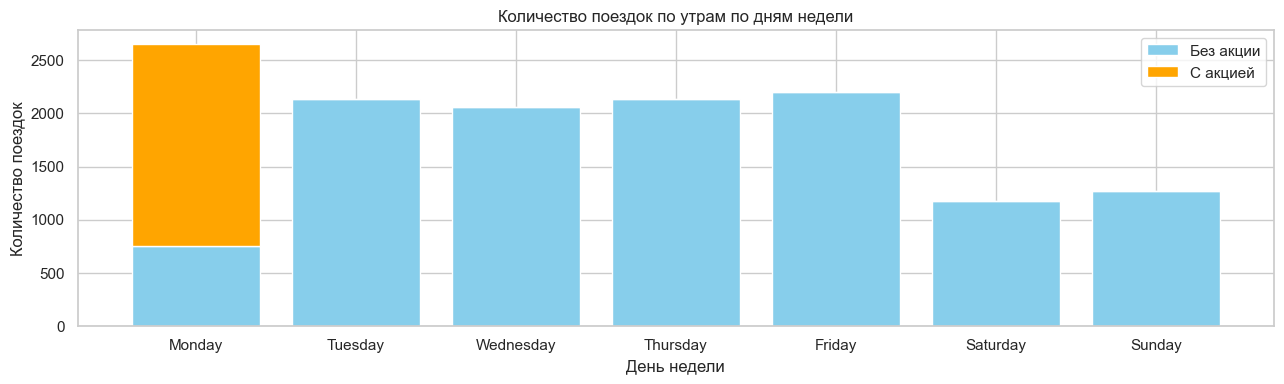

In [125]:
# Группировка данных по наличию акции и дню недели
grouped_data = df.groupby(['day', 'promo']).size().unstack(fill_value=0)

# Переупорядочивание индексов для правильного отображения
grouped_data = grouped_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Построение бар-графика
plt.figure(figsize=(13, 4))
bars = plt.bar(grouped_data.index, grouped_data[0], color='skyblue', label='Без акции')  # Поездки без акции
bars2 = plt.bar(grouped_data.index, grouped_data[1], bottom=grouped_data[0], color='orange', label='С акцией')  # Поездки с акцией
plt.title('Количество поездок по утрам по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Графически видно, что в понедельник спрос действительно гораздо больше и около 70% людей воспользовались акцией

А теперь сравним трафик по часам в понедельник с 6 до 10 с остальными днями

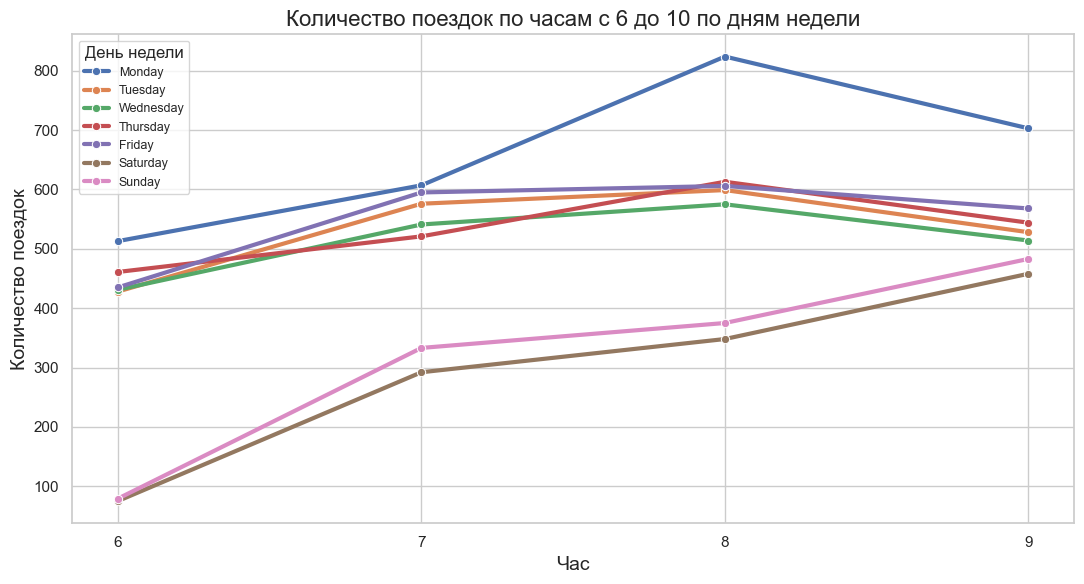

In [127]:
# Создание нового DataFrame для группировки по часам и дням недели
df['hour'] = df['start_date'].dt.hour
hourly_data = df.groupby(['day', 'hour']).size().reset_index(name='traffic')

# Переупорядочивание индексов для правильного отображения
hourly_data['day'] = pd.Categorical(hourly_data['day'], 
                                     categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                                     ordered=True)

# Построение графика
plt.figure(figsize=(11, 6))
sns.lineplot(data=hourly_data, x='hour', y='traffic', hue='day', marker='o', lw=3)
plt.title('Количество поездок по часам с 6 до 10 по дням недели', fontsize=16)
plt.xlabel('Час', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.xticks(hourly_data['hour'].unique())
plt.legend(title='День недели', fontsize=9)
plt.tight_layout()
plt.show()


Трафик в понедельник сопоставим со трафиком в будние дни с 6:00 до 7:00, но с 8:00 до 10:00 наблюдается значительный рост

Дополнительно проверим % людей, которые ездят по акции в понедельник по часам

In [174]:
# Берём только данные по понедельникам
monday_df = df[(df['start_date'].dt.day_name() == 'Monday')]

# Группировка по часам и наличию акции
traffic_counts = monday_df.groupby(['hour', 'promo']).size().unstack(fill_value=0)

# Рассчет общего количества поездок по часам
traffic_counts['total'] = traffic_counts.sum(axis=1)

# Рассчет процента поездок с акцией
traffic_counts['promotion_percentage'] = (traffic_counts[True] / traffic_counts['total']) * 100

# Теперь percentage_data содержит только 'hour' и 'promotion_percentage'
for elem in traffic_counts.reset_index().values:
    print(f'{int(elem[0])}:00 - {round(elem[-1], 1)} %')

6:00 - 71.0 %
7:00 - 73.3 %
8:00 - 69.5 %
9:00 - 72.4 %


Процент людей в среднем всегда равен 70%, значит акция всегда равномерно эффективна и нет смысла её отменять или переносить на другое время.

#### Вывод

На основании проведенного исследования можно сказать, что: 
* Акция действительно стимулирует спрос
* Самый высокий спрос в день проведения акции(понедельник), а самый низкий по выходным
* Спрос на самокаты утром действительно зависит от дня недели

### 3. Исследование корреляцию между параметрами погодных условий

#### Подготовка данных

In [629]:
# Загрузка данных о погоде
df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Приведение колонок к float, кроме колонки с датами
for col in df.columns[1:]:
    df[col] = df[col].astype(float)
    
# Так как в исследледовании мы исследуем только параметры погодных условий, то удаляем datetime
df = df.drop('datetime', axis=1)

#### Первичный анализ

Перед началом исследования стоит понять как распределены данные, чтобы выбрать правильный коэффицент. Будем использовать тест Шапиро-Уилка и графический анализ. Важно добавить, что для параметра sunshine_duration логичнее будет использовать только дневное время, так как ночью солнце не светит.

Сначала проведём тест Шапиро-Уилка.

In [630]:
# Проверяем данные через тест Шапиро-Уилка
for col in df.columns:
    if col == 'sunshine_duration':
        tmp_df = df[df['sunshine_duration'] > 0] # Берём только данные, когда солнце светит
        _, p_value = shapiro(tmp_df[col])
    else:
        _, p_value = shapiro(df[col])
    
    print(f"{col}: p-value = {p_value:.5f}")

temperature: p-value = 0.00001
precipitation_total: p-value = 0.00000
wind_gust: p-value = 0.00000
wind_speed: p-value = 0.00000
cloud_cover_total: p-value = 0.00000
sunshine_duration: p-value = 0.00000


Теперь проведём графический анализ

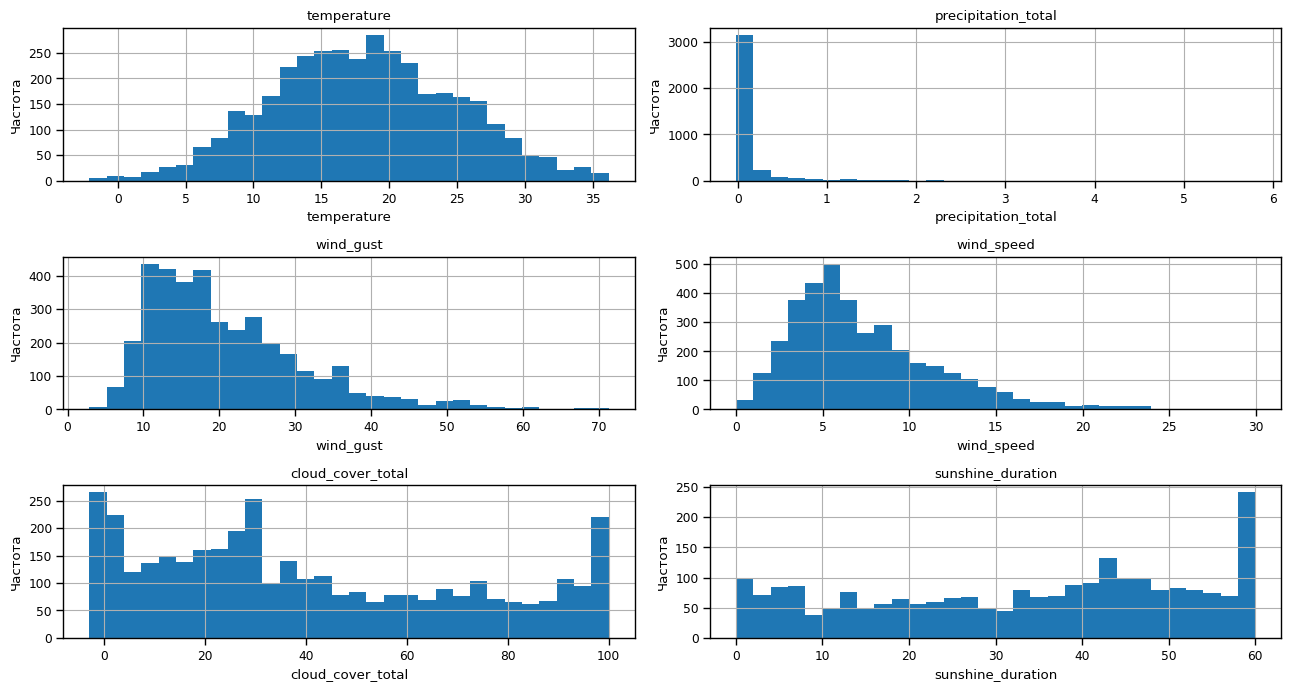

In [631]:
# Рисуем график
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 7))

for i, col in enumerate(df.columns):
    ax = axes[i // 2, i % 2]
    
    if col == 'sunshine_duration':
        df[df['sunshine_duration'] > 0][col].hist(ax=ax, bins=30) # Берём только данные, когда солнце светит
    else:
        df[col].hist(ax=ax, bins=30)

    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()


По данным из теста Шапиро-Уилка и из графиков можно сделать вывод, что все данные распределены ненормально, следовательно, так как все данные количественные, то будет использовать коэффицент Спирмена для поиска корреляций. 

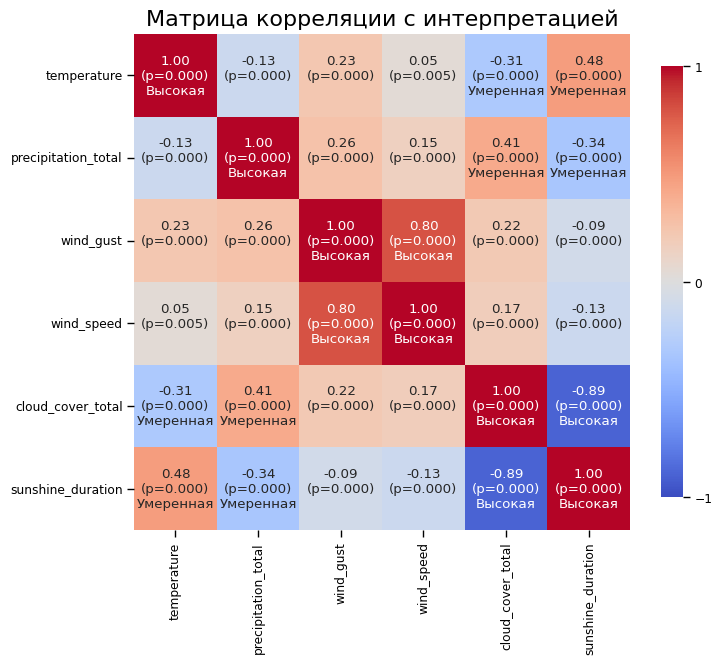

In [632]:
# Расчёт матрицы корреляции и p-value
corr_matrix = df.corr(method='spearman')
p_values = np.zeros_like(corr_matrix)

# Перерасчёт для sunshine_duration, так как нас интересуют только промежутки, когда солнце светило
sunshine_df = df[df['sunshine_duration'] > 0]
sunshine_corr_matrix = sunshine_df.corr(method='spearman')
for col in sunshine_df.columns:
    corr_value, p_val = spearmanr(sunshine_df['sunshine_duration'], sunshine_df[col])
    corr_matrix.loc['sunshine_duration', col] = corr_value
    corr_matrix.loc[col, 'sunshine_duration'] = corr_value
    p_values[sunshine_df.columns.get_loc('sunshine_duration'), sunshine_df.columns.get_loc(col)] = p_val
    p_values[sunshine_df.columns.get_loc(col), sunshine_df.columns.get_loc('sunshine_duration')] = p_val

# Заполняем матрицу p-value
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        _, p_values[i, j] = spearmanr(df.iloc[:, i], df.iloc[:, j])

# Функция для удобной классификации корреляций
def classify_correlation(value: int) -> str:
    if abs(value) >= 0.7:
        return 'Высокая'
    elif abs(value) >= 0.5:
        return 'Заметная'
    elif abs(value) >= 0.3:
        return 'Умеренная'
    else:
        return ''

# Функция для отображения значений корреляции, p-value и их интерпретации
annot = np.empty_like(corr_matrix, dtype=object)
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        correlation = corr_matrix.iloc[i, j]
        p_val = p_values[i, j]
        description = classify_correlation(correlation)
        annot[i, j] = f"{correlation:.2f}\n(p={p_val:.3f})\n{description}"

# Построение heatmap и его настройка
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=annot, fmt="", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8, "ticks": [-1, 0, 1]}, vmin=-1, vmax=1)
plt.title('Матрица корреляции с интерпретацией', fontsize=16)
plt.show()


Все p-value < 0.05, это говорит о том, что между всеми параметрами существует хоть какая-то корреляция, то коэффицент корреляции у многих параметров очень низок, поэтому исследуем данные, где корреляционное значение больше 0.3 или меньше -0.3, то есть данные, как минимум с умеренной корреляцией.

Нам подходят следующие корреляции:

* Умеренные
    1. Облачность и температура (Обратная зависимость)
    2. Облачность и общее количество осадков
    3. Продолжительность солнечного сияния и температура
    4. Количество осадков и продолжительность солнечного сияния (Обратная зависимость)
* Высокая
    1. Скорость ветра и порывы ветра
    2. Продолжительность солнечного сияния и облачность (Обратная зависимость)

#### Умеренные

##### 1. Облачность и температура

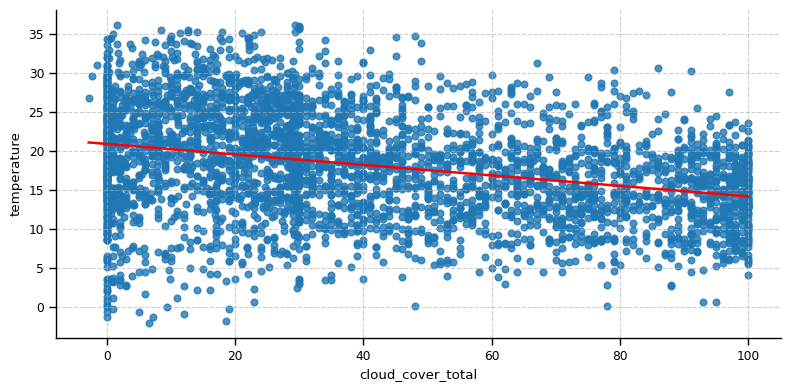

In [633]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="temperature", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается слабая умеренная обратная корреляция между факторами. Её легко объяснить. Когда на небе много облаков, то лучи солнца хуже доходят до земли и нагревают её, следовательно температура падает.

То есть можно сделать вывод, что облачность выступает как ограничивающий фактор для связи между продолжительностью солнечного сияния и температурой, смягчая их влияние. При высокой облачности воздействие солнечного сияния на температуру становится менее выраженным, но корреляция между солнечным сиянием и температурой остается значимой.

##### 2. Облачность и общее количество осадков

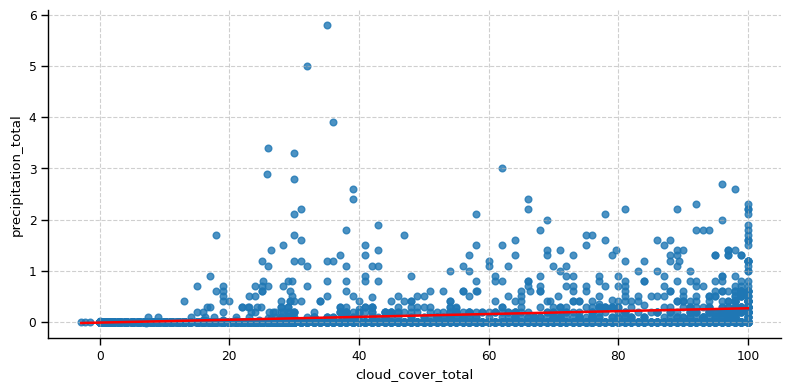

In [634]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="precipitation_total", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается умеренная корреляция между факторами. Её легко объяснить. Когда на небе много облаков, то, вероятно и погода хуже, а следовательно вероятность дождя выше.

То есть можно сделать вывод, что облачность выступает как основной фактор, влияющий на количество осадков.

##### 3. Продолжительность солнечного сияния и температура

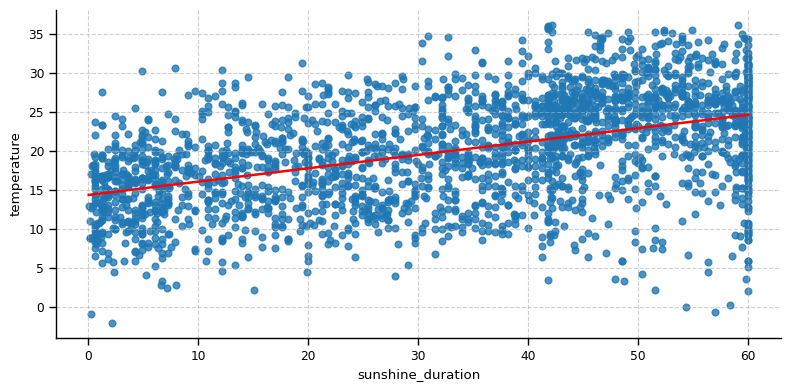

In [635]:
# Берём только время, когда светит солнце
sns.set_context("paper")
sns.lmplot(x="sunshine_duration", y="temperature", data=sunshine_df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции, которое очень близко и заметной, и графическому анализу, наблюдается сильная умеренная корреляция между факторами. Её легко можно объяснить. Чем дольше солнце светит и ему ничего не мешает, то тем сильнее нагревается Земля и растет температура.

То есть можно сделать вывод, что продолжительность солнечного сияния выступает как основной фактор от которого зависит температура.

##### 4. Количество осадков и продолжительность солнечного сияния

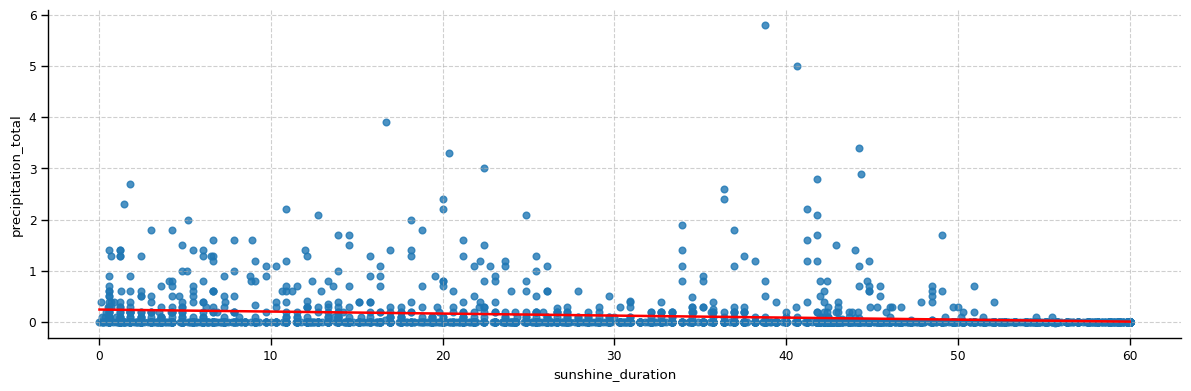

In [636]:
# Берём только время, когда светит солнце
sns.set_context("paper")
sns.lmplot(x="sunshine_duration", y="precipitation_total", data=sunshine_df, ci=None, aspect=3, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается слабая умеренная корреляция между факторами. Её легко можно объяснить. Когда солнце светит, то на небе мало облаков, которые могут ему мешать светить, а без облаков не будет и дождя.

То есть можно сделать вывод, что связь между этими двумя параметрами является следствием из корреляции между: 

* precipitation_total и <u>cloud_cover_total</u>
* sunshine_duration и <u>cloud_cover_total</u>

А так как корреляция между sunshine_duration и cloud_cover_total очень сильная, то её сила передаётся и на precipitation_total, который имеет корреляцию с cloud_cover_total

#### Высокие

##### 1. Скорость ветра и порывы ветра

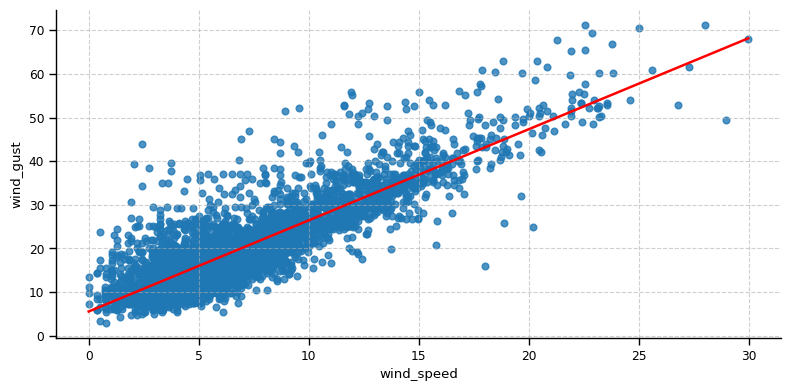

In [637]:
sns.set_context("paper")
sns.lmplot(x="wind_speed", y="wind_gust", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается высокая корреляция между факторами. Её легко можно объяснить. Чем выше скорость ветка, тем соответственно и ветреннее погода, следовательно и больше скорость порывов ветра.

То есть можно сделать вывод, что скорость ветра выступает как основной фактор от которого зависит скорость порывов ветра.

##### 2. Продолжительность солнечного сияния и облачность

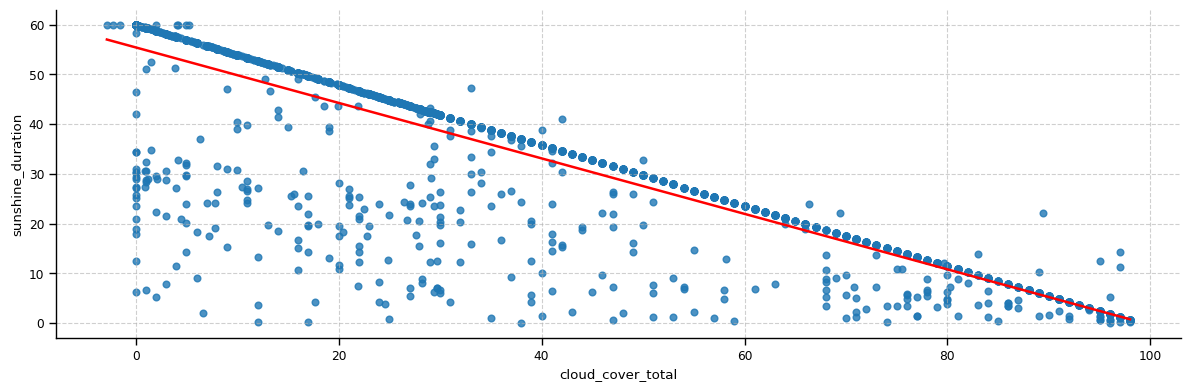

In [638]:
# Берём только время, когда светит солнце
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="sunshine_duration", data=sunshine_df, ci=None, aspect=3, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается очень сильная обратная корреляция между факторами. Её легко можно объяснить. Когда на небе много облаков, то лучи солнца хуже доходят до земли.

То есть можно сделать вывод, что облачность выступает как основной фактор от которого зависит продолжительность солнечного сияния. Данный вывод подкрепляет вывод из первого пункта(1. Облачность и температрура).

#### Вывод

На основе проведенного исследования можно сделать следующие выводы:

- Температура в первую очередь зависит от продолжительность солнечного сияния. Но так же от облачности, которая выступает как ограничивающий фактор для связи между.
- Продолжительность солнечного сияния почти полностью зависит от облачности(зависимость обратная!).
- Общее количество осадков зависит больше всего от облачности.
- Скорость порывов ветра почти полностью зависят от скорости ветра.

### 4. Подготовка таблицы с почасовым трафиком в каждой точке. 


#### Создание таблицы

In [227]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])

In [ ]:
# Аггрегируем приезды и отьезды по часам
arrivals = (df.groupby(['end_location', df['end_date'].dt.floor('h')])
            .size()
            .reset_index(name='arrivals'))

departures = (df.groupby(['start_location', df['start_date'].dt.floor('h')])
              .size()
              .reset_index(name='departures'))

arrivals.rename(columns={'end_location': 'location', 'end_date': 'datetime'}, inplace=True)
departures.rename(columns={'start_location': 'location', 'start_date': 'datetime'}, inplace=True)

# Объединение данных по локации и времени
traffic_by_hours = pd.merge(arrivals, departures, on=['location', 'datetime'], how='outer').fillna(0)

# Считаем общий трафик
traffic_by_hours['total'] = traffic_by_hours['arrivals'] + traffic_by_hours['departures']

# Колонка - месяц
traffic_by_hours['month'] = traffic_by_hours['datetime'].dt.month_name(locale='ru')

traffic_by_hours.head()

datetime     location   month  arrivals  departures  total
0     2023-04-22    береговая  Апрель       9.0         6.0   15.0
1     2023-04-22    березовая  Апрель      13.0        16.0   29.0
2     2023-04-22    буденного  Апрель      21.0        20.0   41.0
3     2023-04-22     вишневая  Апрель      11.0         8.0   19.0
4     2023-04-22   вокзальная  Апрель       7.0        13.0   20.0
...          ...          ...     ...       ...         ...    ...
9195  2023-08-01      садовая  Август       1.0         0.0    1.0
9196  2023-08-01     суворова  Август       1.0         0.0    1.0
9197  2023-08-01      чкалова  Август       1.0         0.0    1.0
9198  2023-08-01     шевченко  Август       1.0         0.0    1.0
9199  2023-08-01  энергетиков  Август       1.0         0.0    1.0

[9200 rows x 6 columns]

#### Выгрузка таблицы

In [120]:
# Сохраняем таблицу
traffic_by_hours.to_csv('traffic_by_hours.csv', index=False)

### 5. Определение топ-3 точки с самым высоким трафиком. 

1. Есть ли точки, которые можно закрыть? 
2. Какие самые популярные направления перемещения? 
3. Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [443]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])
traffic_by_hours = pd.read_csv('traffic_by_hours.csv', parse_dates=['datetime'])

##### Топ-3 точки по общему трафику

In [122]:
top = ((df['start_location'].value_counts() + df['end_location'].value_counts()).to_frame()).sort_values('count', ascending=False)

top.tail(3)

count
степная      1600
набережная   1567
пушкина      1540

##### Топ-3 начальных и конечных точек по трафику 

Начальные

In [123]:
top_start = df['start_location'].value_counts().to_frame()
top_end = df['end_location'].value_counts().to_frame()

top_start.head(3)

count
start_location       
луговая          2293
ломоносова       2292
майская          2235

Конечные

In [124]:
top_end.head(3)

count
end_location       
спортивная     2313
восточная      2286
буденного      2280

Несмотря на то, что мы искали топ-3 улицы, было замечено, что существует резкий рост спроса и в точках старта и в точках конца между значениями в 1550 и 2150. Это позволяет нам говорить об особой категории улиц с супер-сильным трафиком. К супер-улицам будем относить улицы с суммарным трафиком за весь период более 4000. На данный момент к супер-улицам можно отнести: <b>спортивная, восточная, буденного, луговая, майская, ломоносова</b>.

##### 5.1 Есть ли точки, которые можно закрыть?

Чтобы ответить на этот вопрос провизуализируем трафик в каждой точке за все время наблюдения

In [125]:
# Группируем данные по локации и суммируем приезды и отьезды
summary = traffic_by_hours.groupby('location')[['arrivals', 'departures']].sum().reset_index()

summary.head()

location  arrivals  departures
0   береговая     831.0       874.0
1   березовая    1222.0      1227.0
2   буденного    2280.0      2185.0
3    вишневая     892.0       834.0
4  вокзальная     898.0       826.0

In [190]:
# Преобразуем данные в длинный формат для seaborn
traffic = summary.melt(id_vars='location', value_vars=['arrivals', 'departures'],
                   var_name='type', value_name='count')

# Визуализируем данные
plt.figure(figsize=(16, 24))
sns.barplot(traffic, y='location', x='count', hue='type')

plt.title('Трафик в локациях за всё время', fontsize=16)
plt.legend(title='ТИП')

plt.xlabel('Количество')
plt.ylabel('Трафик')

plt.show()

location      type   count
0   береговая  arrivals   831.0
1   березовая  arrivals  1222.0
2   буденного  arrivals  2280.0
3    вишневая  arrivals   892.0
4  вокзальная  arrivals   898.0

По представленной информации сложно сказать стоит ли закрывать какие-либо точки, посмотрим на трафик в точках по месяцам

In [178]:
# Сначала отфильтруем данные, исключив апрель и август, так как мы имеем не полные данные за их период
filtered_traffic = traffic_by_hours[~traffic_by_hours['month'].isin(['Апрель', 'Август'])]

# Группируем данные по локациям и месяцам, суммируем значения приездов и отьездов
traffic_by_months = filtered_traffic.groupby(['location', 'month']).agg({
    'arrivals': 'sum',
    'departures': 'sum',
    'total': 'sum'
}).reset_index()

traffic_by_months.head()

traffic_by_months.sort_values('total').reset_index(drop=True)

location month  arrivals  departures   total
0       пушкина   Май     194.0       222.0   416.0
1    набережная   Май     214.0       203.0   417.0
2        гоголя   Май     221.0       203.0   424.0
3       степная   Май     199.0       226.0   425.0
4          мира   Май     229.0       198.0   427.0
..          ...   ...       ...         ...     ...
268  спортивная  Июль     744.0       723.0  1467.0
269   буденного  Июль     767.0       718.0  1485.0
270     майская  Июль     761.0       761.0  1522.0
271  ломоносова  Июль     757.0       768.0  1525.0
272     луговая  Июль     781.0       764.0  1545.0

[273 rows x 5 columns]

In [179]:
min_values = traffic_by_months.groupby('month').agg(
    min_arrivals=('arrivals', 'min'),
    min_departures=('departures', 'min'),
    min_total=('total', 'min')
).reset_index()

min_values.sort_values('month', ascending=False).reset_index(drop=True)

month  min_arrivals  min_departures  min_total
0   Май         194.0           198.0      416.0
1  Июнь         216.0           228.0      474.0
2  Июль         248.0           242.0      494.0

Минимум из минимумов замечен в мае, что логично, ведь сезон самокатов только начинается, после своего начала в конце апреля

In [476]:
traffic_by_months.query('month == "Май"')[['location', 'total']].sort_values('total').reset_index(drop=True)

location   total
0      пушкина   416.0
1   набережная   417.0
2       гоголя   424.0
3      степная   425.0
4         мира   427.0
..         ...     ...
86  спортивная  1220.0
87  ломоносова  1237.0
88     луговая  1265.0
89   восточная  1285.0
90   буденного  1288.0

[91 rows x 2 columns]

В общем и целом, все точки показывают адекватный трафик.<br>
Можно закрыть точки с наименьшим трафик в мае, но стоит отталкиваться от их положения, чтобы равномерно перераспределить трафик между соседями.

##### 5.2 Какие самые популярные направления перемещения?

In [449]:
df.groupby('start_district')['start_location'].unique().to_dict()

{'заречный': array(['чехова', 'шоссейная', 'комсомольская', 'пионерская', 'садовая',
        'октябрьская'], dtype=object),
 'ленинский': array(['комарова', 'западная', 'свободы', 'подгорная', 'лермонтова',
        'мичурина', 'партизанская', 'карла маркса', 'ленина', 'полевая',
        'кирова', 'колхозная', 'калинина', 'суворова'], dtype=object),
 'октябрьский': array(['буденного', 'восточная', 'майская', 'ломоносова', 'спортивная',
        'луговая'], dtype=object),
 'северо-западный': array(['первомайская', 'новая', 'школьная', 'рябиновая', 'рабочая',
        'заводская', 'красная', 'цветочная', 'строительная', 'некрасова',
        'березовая', 'московская', 'чапаева'], dtype=object),
 'центральный': array(['труда', 'пролетарская', 'зеленая', 'энтузиастов', 'пушкина',
        'солнечная', 'дачная', 'советская', 'дзержинского', 'гагарина',
        'набережная', 'южная', 'строителей', 'матросова', 'крупской',
        'береговая', 'дружбы', 'свердлова', 'куйбышева', 'нагорная',
      

Центральный и Юго-Восточный лидируют по количеству локаций.

In [180]:
# Считаем количество каждого маршрута за все время наблюдения
routes_locations = df.groupby(['start_location', 'end_location']).size().reset_index(name='count')
routes_districts = df.groupby(['start_district', 'end_district']).size().reset_index(name='count')

routes_locations.sort_values(by='count', ascending=False).head(10).reset_index(drop=True) # Выводим самые популярные маршруты между локациями

start_location end_location  count
0      буденного    буденного     68
1        луговая   спортивная     67
2        майская   спортивная     61
3     спортивная      майская     60
4      восточная   ломоносова     59
5     ломоносова   спортивная     58
6        майская    буденного     58
7      восточная      луговая     58
8     спортивная    восточная     58
9        луговая      луговая     57

##### Посмотрим на популярные маршруты в разные месяца

In [173]:
months_names = {4: 'апрель', 5: 'май', 6: 'июнь', 7: 'июль'}

# Новая колонка - месяц
df['month'] = df['start_date'].dt.month.map(months_names) 

Маршруты между локациями

In [189]:
# Группируем маршруты между локациями по месяцам
month_routes_l = df.groupby(['month', 'start_location', 'end_location']).size().reset_index(name='count')

# Таблица с топ 3 маршрутами по месяцам
month_routes_l.groupby('month').apply(lambda x: x.nlargest(3, 'count'), include_groups=False)

start_location end_location  count
month                                          
апрель 1858         луговая   спортивная      9
       1768      ломоносова  октябрьская      8
       2427           новая      луговая      8
июль   11060     спортивная      майская     28
       7886         луговая   спортивная     25
       7757      ломоносова   ломоносова     24
июнь   12850      буденного    буденного     31
       15663     ломоносова   спортивная     24
       18879     спортивная    восточная     24
май    23480        луговая      луговая     23
       20960      восточная   ломоносова     22
       22505  комсомольская    буденного     20

Маршруты между районами

In [175]:
# Группируем маршруты между районами по месяцам
month_routes_d = df.groupby(['month', 'start_district', 'end_district']).size().reset_index(name='count')

# Таблица с топ 3 маршрутами по месяцам
month_routes_d.groupby('month').apply(lambda x: x.nlargest(3, 'count'), include_groups=False)

start_district   end_district  count
month                                          
апрель 28     центральный    центральный    483
       34   юго-восточный    центральный    385
       29     центральный  юго-восточный    357
июль   64     центральный    центральный   2000
       65     центральный  юго-восточный   1670
       70   юго-восточный    центральный   1544
июнь   100    центральный    центральный   1923
       101    центральный  юго-восточный   1547
       106  юго-восточный    центральный   1383
май    136    центральный    центральный   1628
       137    центральный  юго-восточный   1371
       142  юго-восточный    центральный   1351

Неудивительно, что в топе по каждому месяцу находятся маршруты, где есть супер-улицы. <br>
Так же в топе много маршрутов центрального и юго-восточного райнов, это связано с тем, что они имеют наибольшее количество локаций

##### 2.3 Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [202]:
# Переводим данные в формат, удобный для вычислений
pivot = traffic.pivot(index='location', columns='type', values='count').fillna(0)

# Вычисляем остаток самокатов
pivot['Остаток'] = pivot['arrivals'] - pivot['departures']

# Выводим 10 самых больших и 10 маленьких улиц по остатку
top_10 = pivot.nlargest(10, 'Остаток')
bottom_10 = pivot.nsmallest(10, 'Остаток')

print("10 улиц по переизбытку:")
print(top_10[['Остаток']])

print("\n10 улиц по нехватке:")
print(bottom_10[['Остаток']])

10 улиц по переизбытку:
type          Остаток
location             
спортивная      121.0
буденного        95.0
восточная        89.0
ленина           80.0
матросова        78.0
заводская        75.0
вокзальная       72.0
первомайская     69.0
лесная           66.0
мира             59.0

10 улиц по нехватке:
type        Остаток
location           
пионерская   -195.0
пушкина      -124.0
труда         -78.0
дачная        -73.0
колхозная     -73.0
нагорная      -73.0
садовая       -68.0
зеленая       -66.0
куйбышева     -61.0
северная      -58.0


На основе анализа общего трафика можно сделать вывод, что в долгосрочный перспективе самокаты будут скапливаться или полностью пропадать из точки. Поэтому <u>необходимо</u> перераспределять их по точкам.

##### Вывод

На основании проведённого исследования можно сделать следующие выводы:
* **Можно закрывать точки с низким трафиком и большой разницей между приезжающими и уезжающими ???**
* Существует особая категория супер-улиц с самым большим трафиком. На данный момент к супер-улицам можно отнести: <b>спортивная, восточная, буденного, луговая, майская, ломоносова</b>
* Почти все самые популярные маршруты направлены либо из, либо в супер-улицу
* Самокаты <u>необходимо</u> перераспределять в конце дня по точкам. Точки нужно мониторить.
* Районы с наибольшим количеством локаций, имеют больший трафик.

### 6. Изучить накопительное поведение разницы в трафике в каждой точке.

Определить необходимое количество самокатов в каждой точке и в каждом районе
для удовлетворения спроса в полном объеме. <br>
(Предполагаем, что ежедневно в 6:00 самокаты перераспределяются к исходной позиции)

#### Подготовка данных

In [405]:
df = pd.read_csv('traffic_by_hours.csv', parse_dates=['datetime'])

In [406]:
# Корректировка даты наблюдения
df['adjusted_date'] = np.where(
    df['datetime'].dt.hour < 6,
    (df['datetime'] - pd.Timedelta(days=1)).dt.date,
    df['datetime'].dt.date
)

df.head()

location            datetime  arrivals  departures  total   month  \
0  береговая 2023-04-22 10:00:00       1.0         0.0    1.0  Апрель   
1  береговая 2023-04-22 13:00:00       0.0         1.0    1.0  Апрель   
2  береговая 2023-04-22 14:00:00       0.0         2.0    2.0  Апрель   
3  береговая 2023-04-22 17:00:00       1.0         0.0    1.0  Апрель   
4  береговая 2023-04-22 18:00:00       1.0         2.0    3.0  Апрель   

  adjusted_date  
0    2023-04-22  
1    2023-04-22  
2    2023-04-22  
3    2023-04-22  
4    2023-04-22

In [427]:
# Групируем трафик по локациям и дате
traffic_by_days = df.groupby(['location', 'adjusted_date']).agg(
    {"arrivals": "sum",
    "departures": "sum"}
).reset_index()

# Новый столбец - разница между приехавшими и уехавшими самокатами
traffic_by_days['difference'] = traffic_by_days['arrivals'] - traffic_by_days['departures']

# Считаем кумулятивную сумму для разницы трафика
traffic_by_days['cumsum'] = traffic_by_days.groupby('location')['difference'].cumsum()
traffic_by_days.head(10)

location adjusted_date  arrivals  departures  difference  cumsum
0  береговая    2023-04-22       9.0         6.0         3.0     3.0
1  береговая    2023-04-23      10.0         6.0         4.0     7.0
2  береговая    2023-04-24       7.0         6.0         1.0     8.0
3  береговая    2023-04-25       4.0         5.0        -1.0     7.0
4  береговая    2023-04-26       4.0         5.0        -1.0     6.0
5  береговая    2023-04-27       5.0         8.0        -3.0     3.0
6  береговая    2023-04-28       5.0         7.0        -2.0     1.0
7  береговая    2023-04-29      12.0        11.0         1.0     2.0
8  береговая    2023-04-30       5.0        15.0       -10.0    -8.0
9  береговая    2023-05-01       8.0         8.0         0.0    -8.0

Если минимальное значение cumsum будет < 0, то его абсолютное значение станет количеством необходимых самокатов, к которому мы добавим 2 самоката в запас.<br>
В противном случае количество требуемых самокатов будет равно числу отъездов.

In [531]:
traffic_by_days['required_scooters'] = np.where(
    traffic_by_days['cumsum'] < 0,
    abs(traffic_by_days['cumsum']) + 2,  # Запас 2 самоката
    traffic_by_days['departures']  # Количество уезжающих
)
# Количество требуемых самокатов в локацих по дням
scooters = traffic_by_days.drop(['arrivals', 'departures', 'departures', 'difference'],axis=1)
scooters

location adjusted_date  cumsum  required_scooters
0     береговая    2023-04-22     3.0                6.0
1     береговая    2023-04-23     7.0                6.0
2     береговая    2023-04-24     8.0                6.0
3     береговая    2023-04-25     7.0                5.0
4     береговая    2023-04-26     6.0                5.0
...         ...           ...     ...                ...
9186      южная    2023-07-27   -33.0               35.0
9187      южная    2023-07-28   -41.0               43.0
9188      южная    2023-07-29   -40.0               42.0
9189      южная    2023-07-30   -41.0               43.0
9190      южная    2023-07-31   -38.0               40.0

[9191 rows x 4 columns]

#### Графический анализ

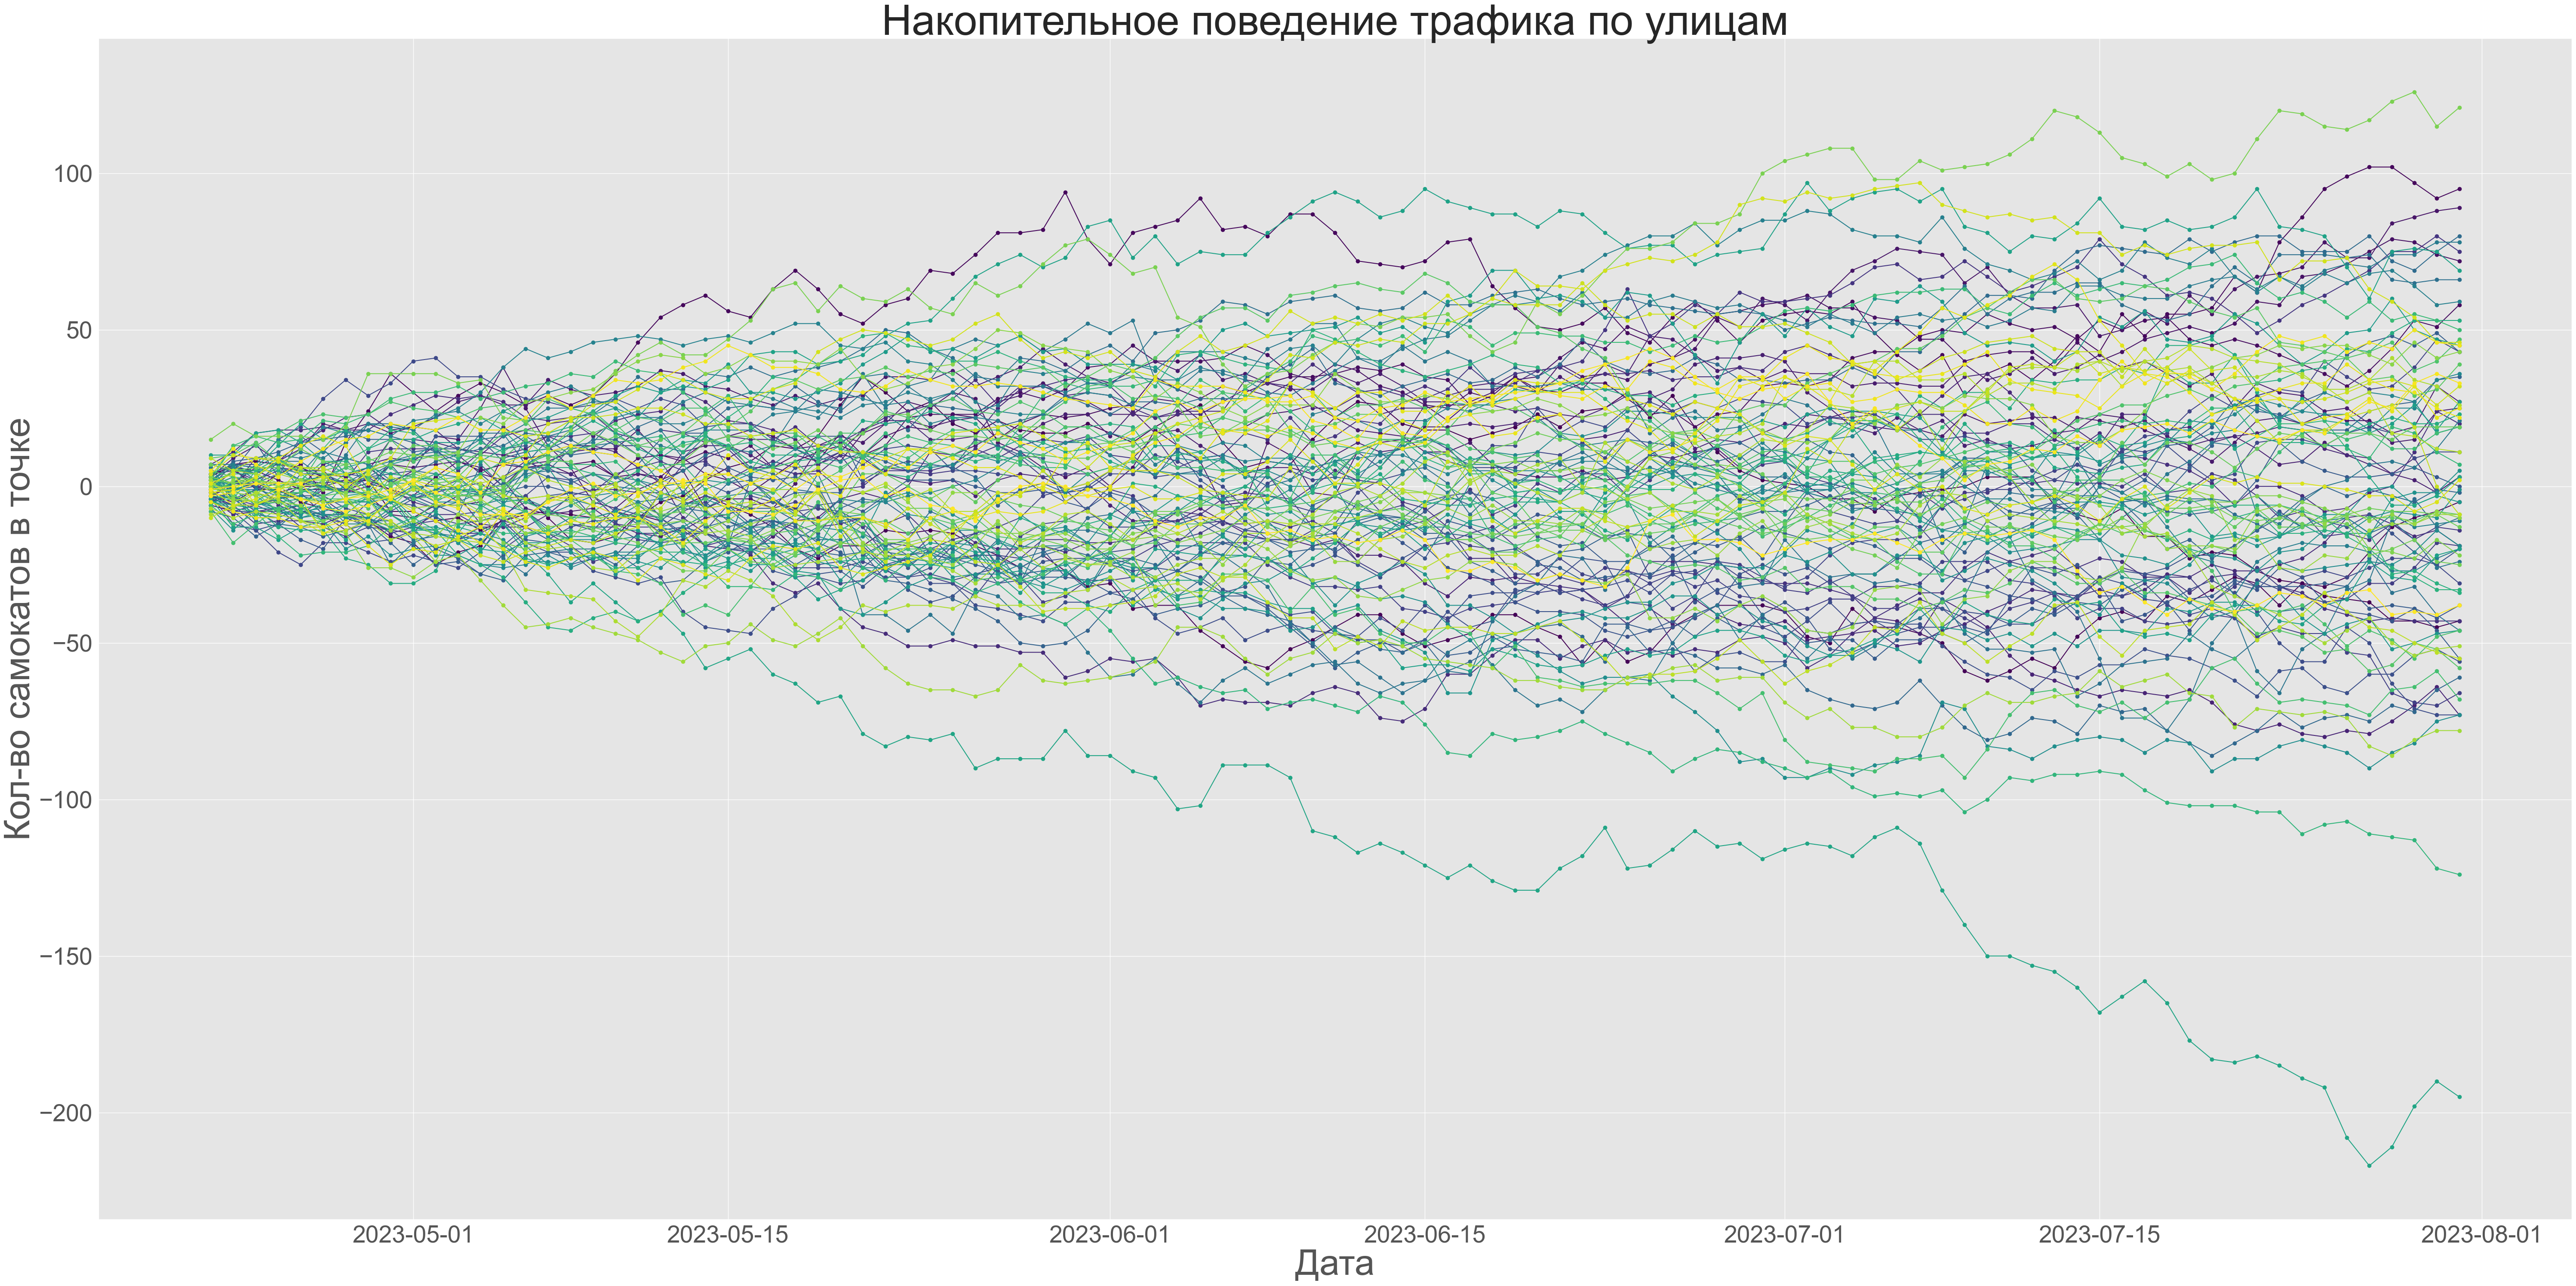

In [551]:
# Визуализация накопительного трафика
plt.figure(figsize=(60, 30))
plt.style.use('ggplot')
colors = plt.cm.viridis(np.linspace(0, 1, len(scooters['location'].unique())))

for i, location in enumerate(scooters['location'].unique()):
    subset = scooters[scooters['location'] == location]
    plt.plot(subset['adjusted_date'], subset['cumsum'], marker='o', label=location, color=colors[i])

plt.title('Накопительное поведение трафика по улицам', fontsize=70)
plt.xlabel('Дата', fontsize=60)
plt.ylabel('Кол-во самокатов в точке', fontsize=60)
plt.xticks(rotation=0, fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.tight_layout()

plt.show()

Для определения необходимого количества самокатов для каждой точки используем максимальное значение required_scooters.

In [539]:
needed_scooters = scooters.rename(columns={'required_scooters': 'scooters'}) \
                            .groupby('location')['scooters'].max() \
                            .round().astype(int).reset_index()

needed_scooters = needed_scooters.sort_values('scooters', ascending=False)

needed_scooters

location  scooters
53   пионерская       219
59      пушкина       126
63      садовая        95
44     нагорная        95
30    куйбышева        88
..          ...       ...
88  энтузиастов        16
41   молодежная        16
4    вокзальная        15
37    матросова        15
89    юбилейная        15

[91 rows x 2 columns]

Провизуализируем данные

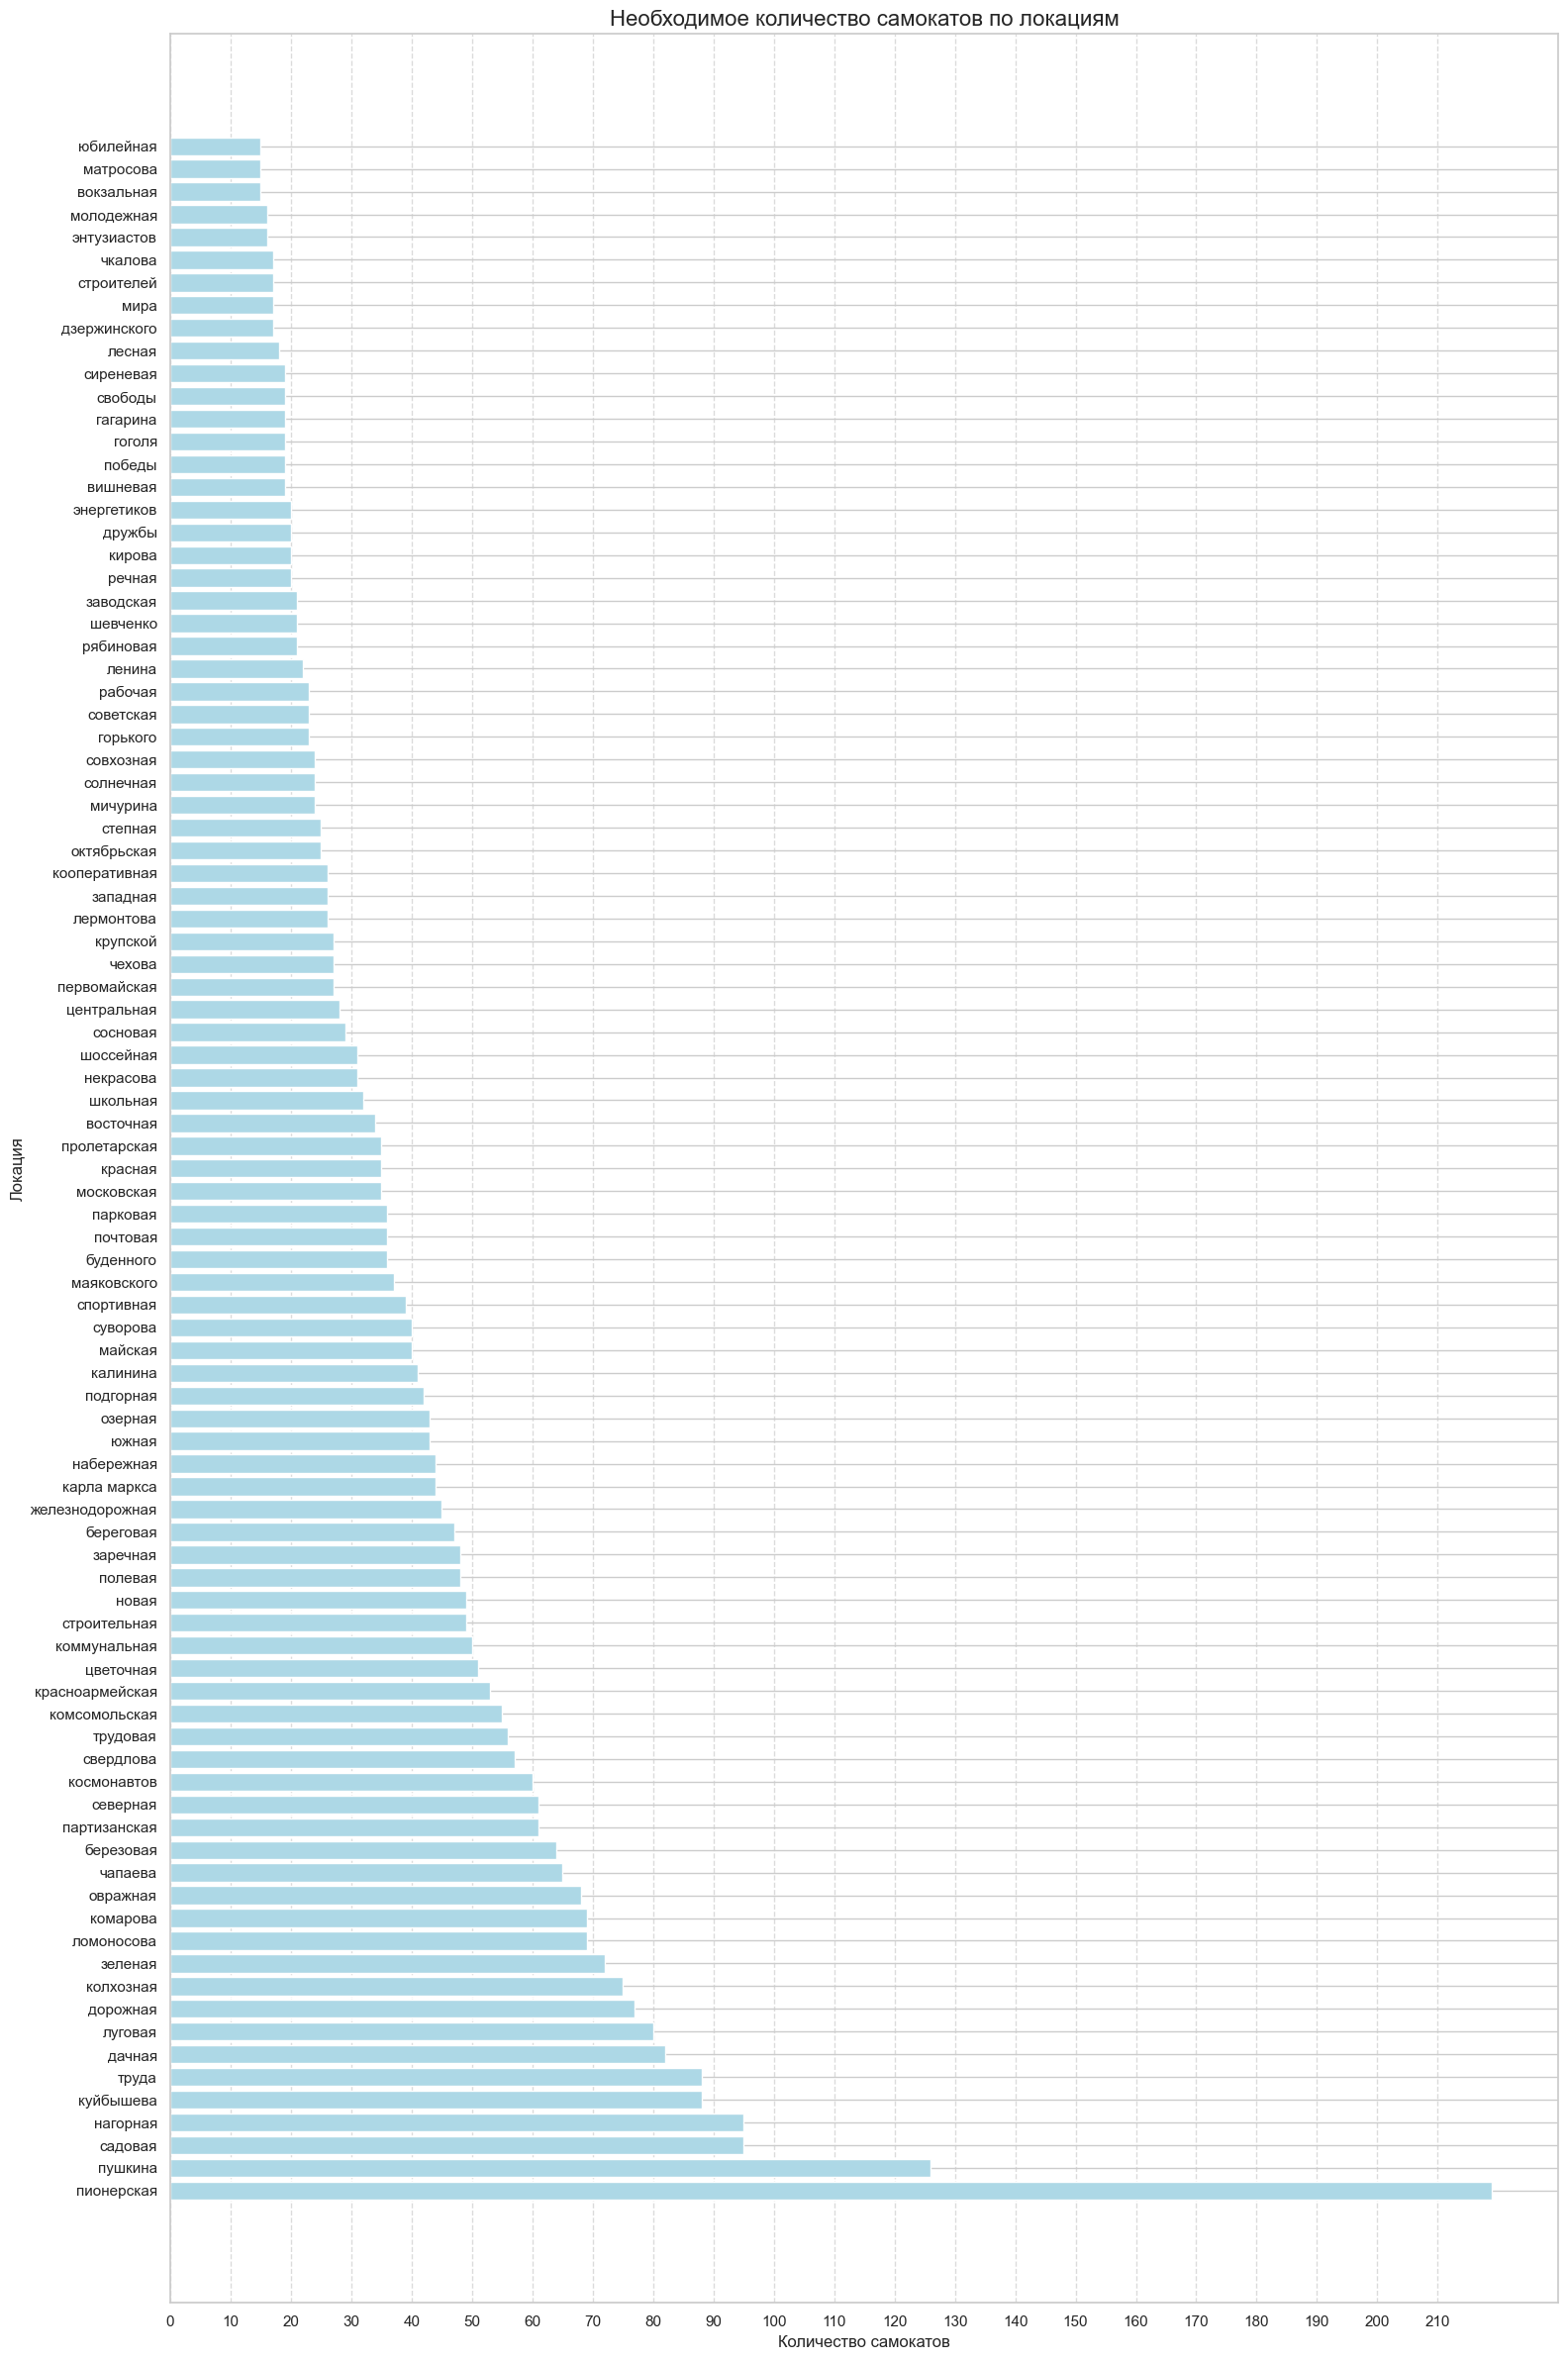

In [541]:

# Создание столбчатой диаграммы
plt.figure(figsize=(16, 24))
plt.barh(y=needed_scooters['location'], width=needed_scooters['scooters'], color='lightblue')

plt.title('Необходимое количество самокатов по локациям', fontsize=16)
plt.xlabel('Количество самокатов')
plt.ylabel('Локация')

plt.xticks(range(0, 220, 10))

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Видно, что пионерская улица требует гораздо больше чем остальные

Посчитаем количество самокатов для каждого района

In [512]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])
# Уникальные локации для каждого района
districts = df.groupby('start_district')['start_location'].unique().reset_index().explode('start_location')

districts.columns = ['district', 'location']
districts.reset_index(drop=True, inplace=True)
districts

district       location
0        заречный         чехова
1        заречный      шоссейная
2        заречный  комсомольская
3        заречный     пионерская
4        заречный        садовая
..            ...            ...
86  юго-восточный       вишневая
87  юго-восточный       дорожная
88  юго-восточный    космонавтов
89  юго-восточный         победы
90  юго-восточный       заречная

[91 rows x 2 columns]

In [548]:
merged_df = pd.merge(districts, needed_scooters, on='location', how='left')

# Группировка по районам и подсчет общего количества самокатов
scooters_by_district = merged_df.groupby('district', as_index=False)['scooters'].sum()

scooters_by_district.sort_values('scooters', ascending=False)

district  scooters
4      центральный      1333
5    юго-восточный       682
1        ленинский       557
3  северо-западный       503
0         заречный       452
2      октябрьский       298

Очевидно что в топе будут находиться районы с наибольшим количеством локаций

#### Вывод

В топе районов по количеству самокатов находятся районы с большим количеством локаций, что может указывать на высокую плотность населения и активный спрос на услуги.<br>Количество требуемых самокатов позволит клиентам не ощущать нехватки транспорта, что, в свою очередь, способствует повышению удовлетворенности пользователей.

### Общий вывод

1. Самый большой спрос на самокаты приходится на вечер с 17 до 22. Средняя стоимость зависит от тарифного плана.
2. Акция сильно влияет на спрос
3. Температура в первую очередь зависит от продолжительность солнечного сияния. Но так же от облачности, которая выступает как ограничивающий фактор для связи между.
4. Общее количество осадков зависит больше всего от облачности.
5. Скорость порывов ветра почти полностью зависят от скорости ветра.
6. Существуют супер-улицы с аномально большим трафиком

## Проверка гипотез

### 1. В дождливое время спрос на самокаты ниже?

H0: Между спросом на самокаты и дождливостью погоды <u>отсутствует</u> корреляция

H1: Между спросом на самокаты и дождливостью погоды <u>существует</u> корреляция

#### Подготовка данных

In [35]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)
    
print(f'Всего временных промежутков: {rides_df.shape[0]}')
print(f'Всего временных промежутков с дождём: {rides_df[rides_df['precipitation_total'] > 0].shape[0]}')
print(f'Всего временных промежутков с умеренным дождём и сильнее: {rides_df[rides_df['precipitation_total'] > 5].shape[0]}')

Всего временных промежутков: 3136
Всего временных промежутков с дождём: 516
Всего временных промежутков с умеренным дождём и сильнее: 1


Из открытых источников известно, что условно принято считать: 
* Cлабый дождь — 1–5 мм/ч 
* Умеренный — 5–20 мм/ч 
* Сильный — 20–40 мм/ч 
* Ливень — более 40 мм/ч 

В ходе подготовки данных о погоде выяснилось, что максимальное значение осадков не превышало 5.8 мм/ч и все дождливые дни, кроме одного, шёл слабый дождь. Поэтому в ходе анализа можно сделать только вывод на счёт слабого дождя. Имеющихся данных недостаточно, чтобы сказать о влиянии других типов дождя на спрос.

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

Сначала проверим влият ли <u>количество</u> осадков на спрос

In [36]:
# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['precipitation_total'], rides_df['rides'])

print(k, p_value)

0.009514361457735945 0.5943078140412971


Теперь проверим влият ли хотя бы какое-то <u>начилие</u> осадков на спрос. То есть теперь нас не волнует сколько было осадков. Нас интересует были ли они или нет.

In [38]:
# Переводим значения столбца в бинарный формат
rides_df['precipitation_total'] = rides_df['precipitation_total'].apply(lambda row: 1 if row > 0 else 0)

# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['precipitation_total'], rides_df['rides'])

print(k, p_value)

0.00853344772391502 0.6328699690146653


#### Вывод

В обоих расчётах значение коэффицента корреляции были близкими к нулю, а p-value были очень далеко от значения < 0.05. Поэтому мы принимаем H0. То есть погода не имеет никакого влияния на спрос на самокаты. Но стоит сказать, что речь идёт только о слабом дожде. То есть вывод таков: Слабый дождь не имеет никакого влияния на спрос на самокаты.

### 2. Отличается ли средняя стоимость поездки по районам?

H0: Средние стоимости поездок по районам <u>равны</u>

H1: Средние стоимости поездок по районам <u>отличаются</u>

#### Подготовка данных

При расчёте итоговой стоимости воспользуемся функцией calculate_income() из исследования 1

In [82]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Расчитываем итоговую стоимость
df = calculate_income(df)

#### Расчёты

Сначала через тест Шапиро-Уилка проверим данные на нормальность

In [83]:
# Проводим тест Шапиро-Уилка
_, p_value = shapiro(df['price'])

print(p_value.round(11))

0.0


Так как p-value < 0.05, то данные распределны ненормально и при расчёте корреляции мы будем использовать критерий Краскера-Уолса, так как групп у нас гораздо больше двух. Проверим зависит ли стоимость от района.

In [92]:
# Группируем по начальной и конечной локации
start_district_groups = df.groupby('start_district')['price'].apply(list)
end_district_groups = df.groupby('end_district')['price'].apply(list)

# Применяем критерий Краскера-Уолса
_, p_value_start = kruskal(*start_district_groups)
_, p_value_end = kruskal(*end_district_groups)

# Интерпретация результата
print(p_value_start < 0.05, p_value_end < 0.05)

True True


Дополнительно проведём графический анализ

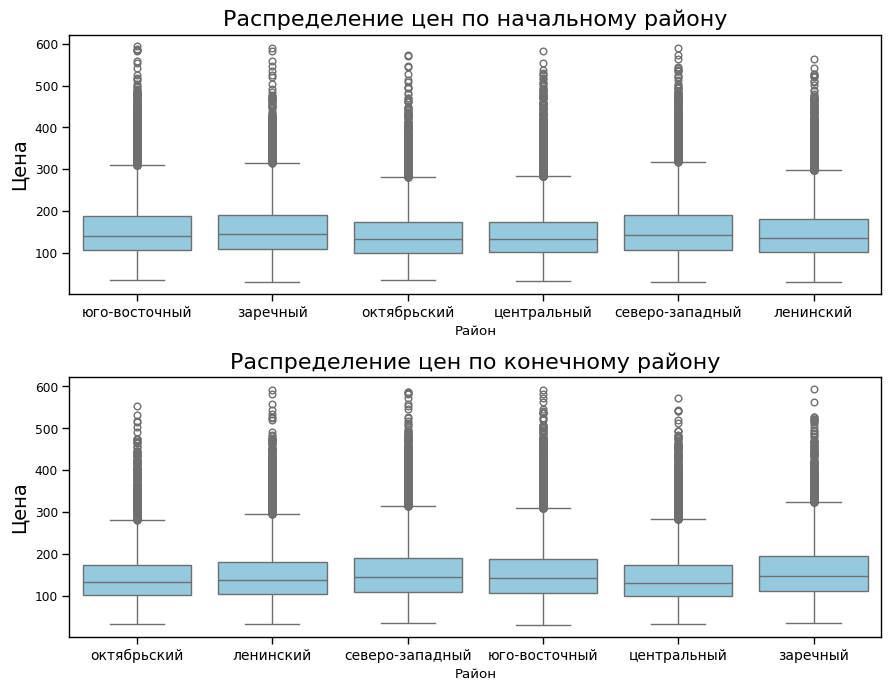

In [ ]:
# Создание графиков
fig, axes = plt.subplots(2, 1, figsize=(9, 7))

# Boxplot для начальной точке
sns.boxplot(x='start_district', y='price', data=df, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение цен по начальному району', fontsize=16)
axes[0].set_xlabel('Район')
axes[0].set_ylabel('Цена поездки', fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, fontsize=10)

# Boxplot для конечной точке
sns.boxplot(x='end_district', y='price', data=df, ax=axes[1], color='skyblue')
axes[1].set_title('Распределение цен по конечному району', fontsize=16)
axes[1].set_xlabel('Район')
axes[1].set_ylabel('Цена поездки', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontsize=10)

# Отображение графиков
plt.tight_layout()
plt.show()

Графически видно обратное - медианы цен почти равны. Проведём дополнительный анализ

In [ ]:
# Группируем по начальной и конечной локации
start_district_groups = df.groupby('start_district')['price']
end_district_groups = df.groupby('end_district')['price']

# Рассчитываем среднее и медиану
start_mean = start_district_groups.mean().round()
start_median = start_district_groups.median().round()

end_mean = end_district_groups.mean().round()
end_median = end_district_groups.median().round()

# Создаем датафрейм, где объединяем данные в единую таблицу для удобного выводы
summary_df = pd.DataFrame({
    'Start District Mean': start_mean,
    'End District Mean': end_mean,
    'Start District Median': start_median,
    'End District Median': end_median
}).fillna(0)

print("Среднее и медиана по начальным и конечным районам:")
print(summary_df)

Среднее и медиана по начальным и конечным районам:
                 Start District Mean  End District Mean  \
заречный                       157.0              160.0   
ленинский                      148.0              149.0   
октябрьский                    143.0              144.0   
северо-западный                157.0              158.0   
центральный                    144.0              142.0   
юго-восточный                  154.0              154.0   

                 Start District Median  End District Median  
заречный                         145.0                148.0  
ленинский                        136.0                137.0  
октябрьский                      132.0                134.0  
северо-западный                  144.0                145.0  
центральный                      134.0                131.0  
юго-восточный                    141.0                142.0  


Размах медиан и средних в среднем составляем порядка 15 рублей. Это довольно таки много. Вероятно, график создает ошибочное впечатление из-за слишком большого шага доходов.

#### Вывод

Оба значения p-value оказались меньше 0.05. После дополнительной проверки оказалось, что разница в средней цене поездки может доходить до 15 рублей. Можно вывод, что средняя стоимость поезки зависит от района, где была начала и закончена поездка, то есть H0 отвергается и остаётся альтернативная гипотеза H1.

Средние стоимости поездок по районам <u>отличаются</u>.

### 3. Спрос на самокаты меняется в зависимости от дня недели?

H0: Спрос на самокаты <u>одинаковый</u> в каждый день недели

H1: Спрос на самокаты <u>варьируется</u> в зависимости от дня недели

#### Подготовка данных

In [105]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Добавление столбца с днем недели
df['day'] = df['start_date'].dt.day_name()

# Подсчет количества поездок по дням недели
rides_per_day = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Группировка данных по дням недели и получение самих значений
grouped_data = [df[df['day'] == day]['id'].values for day in rides_per_day.index]

#### Расчёты

Сначала проведём графический анализ

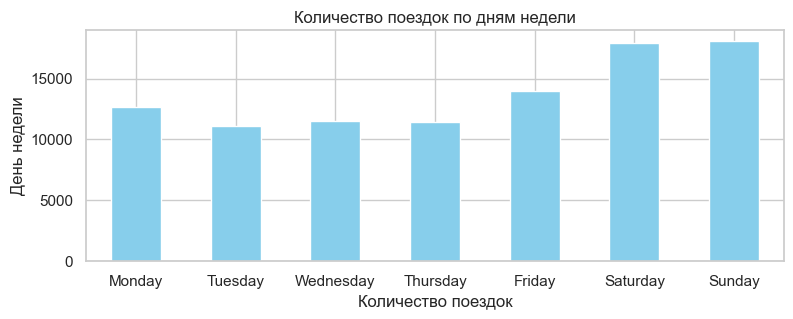

In [176]:
# Визуализация
plt.figure(figsize=(9, 3))
rides_per_day.plot(kind='bar', color='skyblue')
plt.title('Количество поездок по дням недели')
plt.xlabel('Количество поездок')
plt.ylabel('День недели')
plt.xticks(rotation=0)
plt.show()


Проверим данные на нормальность

In [177]:
results = {day: shapiro(data) for day, data in zip(rides_per_day.index, grouped_data)}

# Вывод результатов теста на нормальность
for day, (stat, p) in results.items():
    print(f"{day}, {p < 0.05}")

Monday, True
Tuesday, True
Wednesday, True
Thursday, True
Friday, True
Saturday, True
Sunday, True


Можно сделать вывод, что все данные распределны ненормально, следовательно мы будем использовать критерий Краскера-Уолса

In [178]:
# Проведение теста Краскала-Уоллиса
_, p_value = kruskal(*grouped_data)

print(p_value.round(20))

0.0


Судя по p-value, существует сильная зависимость между днём недели и спросом на самокаты. 

#### Вывод

Исходя из графического и анатитического анализа, получается, что зависимость существует и мы отвергает H0. То есть спрос на самокаты <u>зависит</u> от дня недели. Также стоит сказать, что самый сильный спрос по выходным, а самый низкий с вторника по четверг.

### 4. В выходные дни поездки более длинные

H0: Длительности поездок в выходные и будние дни <u>равны</u>

H1: Длительности поездок в выходные и будние дни <u>отличаются</u>

#### Подготовка данных

In [539]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Рассчитываем длительность поездки в минутах
df['time_delta'] = df['end_date'] - df['start_date']
df['time_delta'] = df['time_delta'].dt.seconds / 60

# Задаем порядок дней недели
df['day'] = df['start_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days_order, ordered=True)

#### Проверка корреляции

Сначала проверим с помощью теста Шапиро-Уилка, как распределены данные о длительности поездки

In [540]:
_, p_value = shapiro(df['time_delta'])

print(p_value < 0.05)

True


Так как p-value < 0.05, то данные распределены ненормально и при расчёте корреляции мы будем использовать тест Манна-Уитни

In [541]:
# Создаем колонку для определения выходного или буднего дня
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

# Разделяем данные на две группы
weekday_durations = df[df['is_weekend'] == False]['time_delta']
weekend_durations = df[df['is_weekend'] == True]['time_delta']

# Выполняем тест Манна-Уитни
_, p_value = mannwhitneyu(weekday_durations, weekend_durations)

# Выводим результаты
print(p_value < 0.05)

True


Действительно, так как p_value < 0.05, то корреляция существует

#### Графический анализ

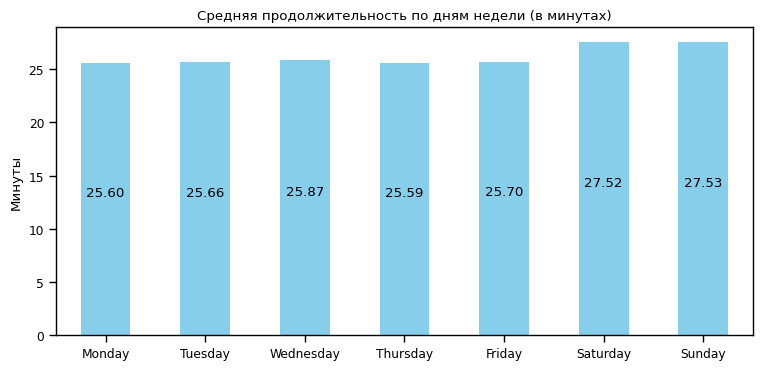

In [542]:
# Считаем средне время поездки и переводим его в минуты
mean_price_df = df.groupby(by=['day'])['time_delta'].mean()

# Создаем график
plt.figure(figsize=(9, 4))
bars = mean_price_df.plot(kind='bar', color='skyblue')

# Подписываем бары с округлением до сотых
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() / 2, 
             f'{bar.get_height():.2f}',
             ha='center', 
             va='bottom')

plt.title('Средняя продолжительность по дням недели (в минутах)')
plt.xlabel('')
plt.ylabel('Минуты')
plt.xticks(rotation=0)
plt.show()

Графически действительно видно, что в выходные средняя длительности больше

#### Вывод

Так как значение p_value < 0.05, то мы отвергаем H0. То есть длительности поездко в выходные и будние дни <u>отличаются</u>, а точнее в выходные дни поездки длиннее, чем в будние. Но также стоит сказать, что на основании графического анализа можно сделать вывод, что хоть сильная зависимость и есть, но она средне сильно влият на среднюю длительность поездки. Разница между значениями в будние и выходные составляет примерно 7% (2 минуты).

### 5. В будние дни поездки более скоростные

H0: Скорости поездкок в выходные и будние <u>равны</u>

H1: Скорости поездкок в выходные и будние <u>отличаются</u>

#### Подготовка данных

In [106]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Создаем колонну ride_duration, которая содержит длительность поездки в минутах
df['ride_duration'] = (df.end_date - df.start_date).dt.seconds / 60 

# Создаем колонку average_speed, которая хранит среднюю скорость на протяжении всего пути в км/ч
df['average_speed'] = (df.distance / 1000) / (df.ride_duration / 60)

# Задаем порядок дней недели
df['day'] = df['start_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days_order, ordered=True)

#### Проверка корреляции

Сначала проверим с помощью теста Шапиро-Уилка, как распределены данные о средней скорости

In [107]:
_, p_value = shapiro(df['average_speed'])

print(p_value < 0.05)

True


Так как p-value < 0.05, то данные распределены ненормально и при расчёте корреляции мы будем использовать тест Манна-Уитни

In [108]:
# Создаем колонку для определения выходного или буднего дня
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

# Разделяем данные на две группы
weekday_durations = df[df['is_weekend'] == False]['average_speed']
weekend_durations = df[df['is_weekend'] == True]['average_speed']

# Выполняем тест Манна-Уитни
_, p_value = mannwhitneyu(weekday_durations, weekend_durations)

# Выводим результаты
print(p_value < 0.05)

True


Действительно, так как p_value < 0.05, то корреляция существует

#### Графический анализ

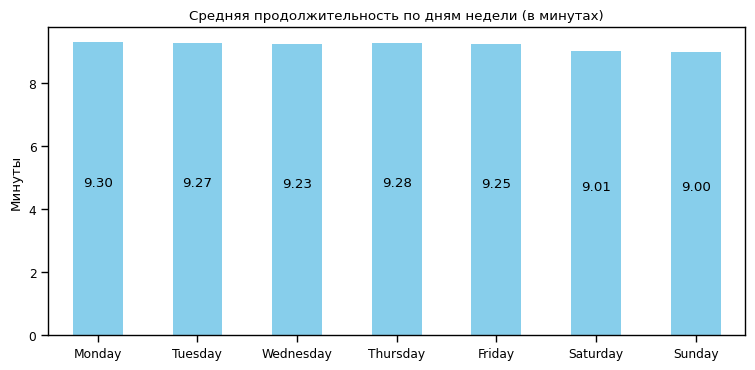

In [109]:
# Считаем средню скорость поездки
mean_price_df = df.groupby(by=['day'])['average_speed'].mean()

# Создаем график
plt.figure(figsize=(9, 4))
bars = mean_price_df.plot(kind='bar', color='skyblue')

# Подписываем бары с округлением до сотых
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() / 2, 
             f'{bar.get_height():.2f}',
             ha='center', 
             va='bottom')

plt.title('Средняя продолжительность по дням недели (в минутах)')
plt.xlabel('')
plt.ylabel('Минуты')
plt.xticks(rotation=0)
plt.show()

#### Вывод

Так как значение p_value < 0.05, то мы отвергаем H0. То есть скорость во время поездки <u>отчичается</u> в выходные и будние дни. Но также стоит сказать, что на основании графического анализа можно сделать вывод, что зависимость является обратной. То есть по выходным средняя скорость поездок наоборот меньше. Также стоит сказать, что в среднем значение скорости меняется не очень сильно, всего на 0.25 км/ч меньше по выходным.

### 6. Спрос зависит от температуры на улице

H0: Между температурой на улице и спросом на самокаты <u>отсутствует</u> корреляция

H1: Между температурой на улице и спросом на самокаты <u>существует</u> корреляция

#### Подготовка данных

In [57]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

In [58]:
# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['temperature'], rides_df['rides'])

print(k.round(3), p_value < 0.05)

0.338 True


Хоть p_value < 0.05, значение коэффицента составляет всего 0.338, что говорит о едва заметной связи между факторами.

#### Вывод

Спрос на самокаты очень слабо зависит от температуры на улице. А следовательно и солнечное сияние с облачностью не имеют даже слабого влияния на спрос(см. исследование 3).

### 7. Спрос зависит от скорости ветра на улице

H0: Между скоростью ветра на улице и спросом на самокаты <u>отсутствует</u> корреляция

H1: Между скоростью ветра на улице и спросом на самокаты <u>существует</u> корреляция

#### Подготовка данных

In [ ]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

In [174]:
# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['wind_speed'], rides_df['rides'])

print(k.round(3), p_value < 0.05)

0.213 True


Хоть p_value < 0.05, значение коэффицента составляет всего 0.213, что говорит о том, что между факторами нет никакой связи.

#### Вывод

Спрос на самокаты <u>не зависит</u> от скорости ветра на улице

### Общий вывод

1. Спрос не зависит от дождя
2. Средние стоимости поездок по районам <u>отличаются</u>
4. Спрос на самокаты зависит от дня недели и выше всего в выходные
4. В выходные дли поездки более длинные
5. В будние дни поездки быстрыее, чем в выходные
6. Спрос на самокаты не зависит от температуры на улице
7. Спрос на самокаты не зависит от скорости ветра на улице

## Регрессионное моделирование

### Подготовка данных

In [289]:
rides_df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Новый df почасовых поездок во всех точках
rides_per_hour = rides_df.groupby(rides_df['start_date'].dt.round('h')).size().reset_index(name='rides')

rides_per_hour.rename(columns={'start_date': 'datetime'}, inplace=True)

# Обьединеям данные о почасовых поездках и погоде
df = pd.merge_asof(
    rides_per_hour, 
    weather_df, 
    on='datetime',
    direction='backward'
)

df.head()

datetime  rides temperature precipitation_total  wind_gust  \
0 2023-04-22 09:00:00     10   13.850245                 0.0      20.16   
1 2023-04-22 10:00:00     29   16.230246                 0.0       23.4   
2 2023-04-22 11:00:00     38   17.080246                 0.1  41.760002   
3 2023-04-22 12:00:00     36   18.130245                 0.0  29.519999   
4 2023-04-22 13:00:00     42   18.370245                 0.0  20.880001   

  wind_speed cloud_cover_total sunshine_duration  
0  6.2145634              71.0         16.969696  
1   5.815978              88.0          6.666666  
2   8.699793              94.0         3.0303025  
3  10.685391              22.2         46.545456  
4  15.782622              38.0         36.969692

### Создание новых признаков и определение факторов

После проведения исследований и проверки гипотез мы выделели основные факторы, которые оказывают влияние на спрос самокатов. К ним относятся:
* Время (в часах)
* День недели
* Выходной ли день
* Вечер ли
* Утро ли
* Проведена ли акция

Так же добавим лаговые факторы ( на час и на день) и среднее значение поездок за 3 часа

In [290]:
# Добавляем новые факторы
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_of_week + 1

df['is_promo_time'] = df['day_of_week'] == 1 & df['hour'].between(6, 9)
df['is_weekend'] = df['day_of_week'] >= 6
df['is_evening'] = df['hour'].between(16, 21)
df['is_morning'] = df['hour'].between(6, 10)

# Лаговые значения спроса
df['lag_1'] = df['rides'].shift(1) # Лаг на час
df['lag_24'] = df['rides'].shift(24)  # Лаг на день

# Средние значения поездок за последние 3 часа
df['rides_mean_3h'] = df['rides'].shift(1).rolling(window=3).mean()

# Удаляем строки с NaN, которые появились из-за сдвига
df.dropna(inplace=True)

# Используем one hot encoder для часа и дня недели, т.к. это категориальные признаки
OHE = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' для избежания мультиколлинеарности

# Применяем OHE к hour и day_of_week
encoded_features = OHE.fit_transform(df[['hour', 'day_of_week']])

# Создаем DataFrame с закодированными признаками
encoded_df = pd.DataFrame(encoded_features, columns=OHE.get_feature_names_out(['hour', 'day_of_week']))

# Объединяем закодированные признаки с оригинальным DataFrame
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Удаляем старые категориальные факторы, а также наименее значимые погодные факторы
df.drop(['hour', 'day_of_week'], axis=1, inplace=True)
df.drop(['cloud_cover_total', 'sunshine_duration', 'wind_gust', 'wind_speed'], axis=1, inplace=True)

### Тренировка модели

In [291]:
X = df.drop(columns=['datetime', 'rides'])
y = df['rides']

# Разделяем данные для анализа
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 2: Обучение модели линейной регрессии
model = LinearRegression()

# Обучение на всех тренировочных данных
model.fit(X_train, y_train)
print('')

### Проверка работы

In [292]:
# Прогнозирование
y_pred = model.predict(X_test).round().astype(int)

# Обработка отрицательных значений (если такие появляются)
y_pred = np.maximum(y_pred, 0)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод интерпретации результатов
print(f"=== Результаты оценки модели ===")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"R² (R-squared): {r2:.2f}")

=== Результаты оценки модели ===
MSE (Mean Squared Error): 93.25
MAE (Mean Absolute Error): 7.22
R² (R-squared): 0.90


### Визуализация результата работы модели

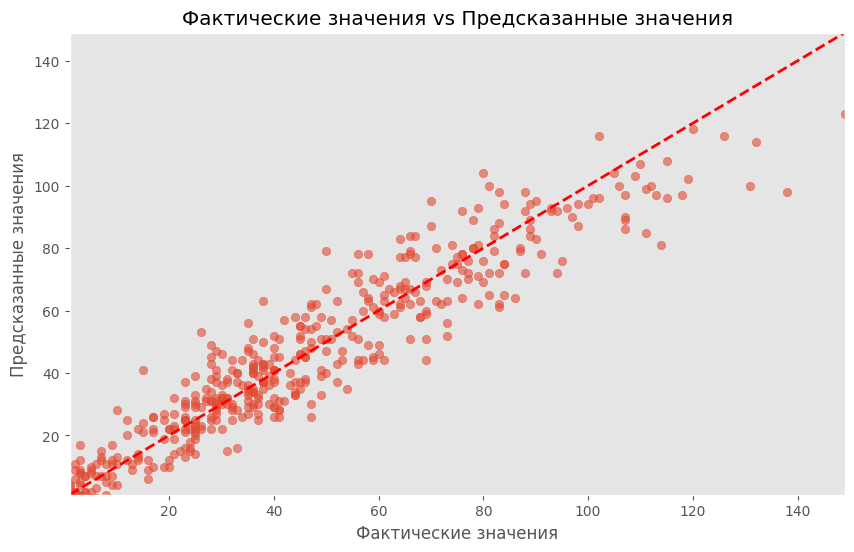

In [294]:
# График рассеяния: фактические значения против предсказанных
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Линия y=x
plt.title('Фактические значения vs Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()


#### Вывод по регрессионой модели
В ходе оценки регрессионной модели были получены следующие ключевые метрики:
* Средняя квадратичная ошибка (MSE): 93.25
* Средняя абсолютная ошибка (MAE): 7.22
* Коэффициент детерминации (R²): 0.90

Наша регрессионная модель показывает хорошие результаты в предсказании количества поездок на самокате, хотя и не является идеальной.

Основные моменты:
* Точность: <br>
        Модель демонстрирует приемлемую точность, с низкими значениями средних ошибок (MSE и MAE), что говорит о том, что предсказания в целом близки к реальным данным.
    
* Объяснительная сила: <br>
        С коэффициентом детерминации (R²) на уровне 0.90, модель объясняет большую часть вариации в количестве поездок, что свидетельствует о ее полезности.

Хотя модель не совершенна и может иметь свои ограничения, она все же способна справляться с предсказаниями и предоставлять ценные инсайты для бизнеса.<br>
Рекомендуется продолжать ее доработку и тестирование на новых данных для повышения точности.